# 基于MindSpore框架的Faster-Rcnn案例实现

## 1 模型简介

Faster-RCNN模型于2016年在论文《Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks》中被提出，它的提出是为了改进Fast-RCNN区域候选算法运行时间长的问题。

Faster-RCNN模型是在Fast-RCNN模型的基础上建立的，由于目标检测网络依靠区域候选算法（如Selective Search）来假设目标的位置，运算时间开销很大，于是Faster-RCNN提出了一个可以共享卷积特征图的深度全卷积网络RPN来代替区域候选算法，使用RPN网络产生的候选区域进行分类与边框回归计算，从而大大加快了运行速度。

### 1.1 模型结构
Faster R-CNN是个两阶段的目标检测方法，主要由提取候选区域的全卷积网络RPN与Fast R-CNN检测器组成，整个检测过程通过一个网络完成。RPN和Fast R-CNN的配合作用可以理解为一种注意力机制，先大致确定目标在视野中的位置，然后再锁定目标仔细观察，确定目标的类别和更加准确的位置。 图1为论文中给出的Faster-RCNN基本结构图。

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://cdn.jsdelivr.net/gh/Jonydom/myPic/img/20221020151403.png">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">图1 Faster-RCNN基本结构图</div>
</center>


Faster R-CNN检测部分主要可以分为以下四个模块：

（1）Conv layers特征提取网络，采用VGG16、ResNet等常用结构作为特征提取的模块，用于提取输入图像特征。然后将提取得到的图像特征feature maps用于后续的RPN层生成一系列可能的候选框。

（2）RPN候选检测框生成网络，该网络替代了之前Fast R-CNN版本的Selective Search，用于生成候选框proposal ，输出为一系列候选框以及每个候选框框中目标的概率值。

（3）RoI Pooling兴趣域池化，以RPN网络输出的兴趣区域和Conv layers输出的图像特征为输入，将两者进行综合后得到固定大小的区域特征图，后续将其送入全连接层继续做目标分类和坐标回归。

（4）Classification and Regression分类与回归。利用上一层得到的区域特征图通过softmax对图像进行分类，并通过边框回归修正物体的精确位置，输出兴趣区域中物体所属的类别以及物体在图像中精确的位置。

### 1.2 模型特点

a) 使用RPN来生成候选区域，完全使用CNN解决目标检测任务，将特征提取、候选框选取、边框回归和分类都整合到一个网络中；

b) 由于RPN网络共享backbone的输出特征图，可以使用GPU加速，使得进行目标检测的速度得到极大提升；

c) 为了处理好物体检测中的多尺度变化问题，在模型backbone骨干网络ResNet50之后引入FPN特征金字塔的网络结构。



## 2 案例实现

### 2.1 环境准备与数据读取

#### 2.1.1 数据获取
本案例基于MindSpore-Ascend版本实现，在ModelArts平台上完成模型训练。

案例实现所使用的数据来自MS coco2017数据集，由于coco2017数据集数据量太大，故经过采样脚本对其进行裁剪，生成minicoco2017数据集，其包括3个文件夹，分别对应标签、训练集样本、验证集样本，文件路径结构如下：

```
.minicoco2017/
├── annotations
│   ├── train2017.json
│   ├── val2017.json
├── train2017
│   ├── 000000001311.jpg
│   ├── 000000030345.jpg
│   └── ......
└── val2017
    ├── 000000078469.jpg
    ├── 000000099598.jpg
    └── ......
```

其中，annotations文件中有两个json文件，分为对应训练集和验证集的标签数据；train2017文件夹中包含30张训练图片，val2017文件夹中包含10张验证图片。minicoco2017数据集从coco2017数据集的80个分类中选择了3个分类：person、airplane、car。

具体裁剪的实现方式：首先读取coco2017中目标检测标注文件instances_train2017.json，选择指定的三个分类；其次，根据这三个分类的id选择与其相关的所有图片，再对这些图片进行随机采样，选择30张作为训练集，选择10张作为验证集；最后，根据40张图片的id找出它们对应的标注信息。将上述图片和标注信息按照coco数据集文件的排列方式存储在本地。


/home/ma-user/anaconda3/envs/MindSpore/bin/python
MindSpore version:  1.8.1
The result of multiplication calculation is correct, MindSpore has been installed successfully!
None
训练集部分数据图片展示：


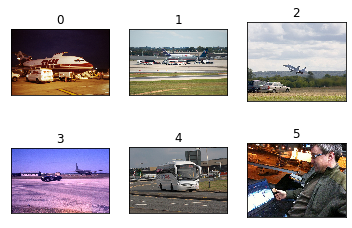

验证集部分数据图片展示：


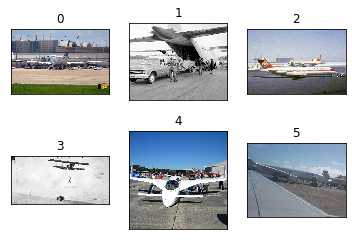

In [1]:
import sys
import mindspore
print(sys.executable)
print(mindspore.run_check())

from PIL import Image, ImageSequence
import math
import os
import numpy as np
import matplotlib.pyplot as plt

train_img_path = "./minicoco2017/train2017"
val_img_path = "./minicoco2017/val2017"
train_images = [os.path.join(train_img_path, filename) for filename in os.listdir(train_img_path)]
val_images = [os.path.join(val_img_path, filename) for filename in os.listdir(val_img_path)]
train_images = np.array([np.array(Image.open(p)) for p in train_images])
val_images = np.array([np.array(Image.open(p)) for p in val_images])

def show_image(image_list,num = 6):
    img_titles = []
    img_draws = []
    for ind,img in enumerate(image_list):
        if ind == num:
            break
        img_titles.append(ind)
        img_draws.append(img)

    for i in range(len(img_titles)):
        if len(img_titles) > 6:
            row = 3
        elif 3<len(img_titles)<=6:
            row = 2
        else:
            row = 1
        col = math.ceil(len(img_titles)/row)
        plt.subplot(row,col,i+1),plt.imshow(img_draws[i],'gray')
        plt.title(img_titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
print("训练集部分数据图片展示：")
show_image(train_images,num = 6)
print("验证集部分数据图片展示：")
show_image(val_images,num = 6)

### 2.1.2 config配置
本案例实现过程中需要多个配置参数，比如batch、epoch、数据集的路径、生成anchor的参数、resnet的参数、fpn的参数、learning rate、loss函数的参数等等。为了案例代码的简洁性和修改参数的便利性，故将这些配置参数封装进一个类`config`中。参数的配置如下所示。

In [2]:
class config:
    device_target = 'Ascend'
    img_width = 1280
    img_height = 768
    keep_ratio = False
    flip_ratio = 0.5
    expand_ratio = 1.0

    # anchor
    feature_shapes = [[192, 320], [96, 160], [48, 80], [24, 40], [12, 20]]
    anchor_scales = [8]
    anchor_ratios = [0.5, 1.0, 2.0]
    anchor_strides = [4, 8, 16, 32, 64]
    num_anchors = 3

    # resnet
    resnet_block = [3, 4, 6, 3]
    resnet_in_channels = [64, 256, 512, 1024]
    resnet_out_channels = [256, 512, 1024, 2048]
    # fpn
    fpn_in_channels = [256, 512, 1024, 2048]
    fpn_out_channels = 256
    fpn_num_outs = 5

    # rpn
    rpn_in_channels = 256
    rpn_feat_channels = 256
    rpn_loss_cls_weight = 1.0
    rpn_loss_reg_weight = 1.0
    rpn_cls_out_channels = 1
    rpn_target_means = [0., 0., 0., 0.]
    rpn_target_stds = [1.0, 1.0, 1.0, 1.0]

    # bbox_assign_sampler
    neg_iou_thr = 0.3
    pos_iou_thr = 0.7
    min_pos_iou = 0.3
    num_bboxes = 245520
    num_gts = 128
    num_expected_neg = 256
    num_expected_pos = 128

    # proposal
    activate_num_classes = 2
    use_sigmoid_cls = True

    # roi_align
    class roi_layer:
        type = 'RoIAlign'
        out_size = 7
        sample_num = 2
    roi_align_out_channels = 256
    roi_align_featmap_strides = [4, 8, 16, 32]
    roi_align_finest_scale = 56
    roi_sample_num = 640

    # bbox_assign_sampler_stage2
    neg_iou_thr_stage2 = 0.5
    pos_iou_thr_stage2 = 0.5
    min_pos_iou_stage2 = 0.5
    num_bboxes_stage2 = 2000
    num_expected_pos_stage2 = 128
    num_expected_neg_stage2 = 512
    num_expected_total_stage2 = 512

    # rcnn
    rcnn_num_layers = 2
    rcnn_in_channels = 256
    rcnn_fc_out_channels = 1024
    rcnn_loss_cls_weight = 1
    rcnn_loss_reg_weight = 1
    rcnn_target_means = [0., 0., 0., 0.]
    rcnn_target_stds = [0.1, 0.1, 0.2, 0.2]

    # train proposal
    rpn_proposal_nms_across_levels = False
    rpn_proposal_nms_pre = 2000
    rpn_proposal_nms_post = 2000
    rpn_proposal_max_num = 2000
    rpn_proposal_nms_thr = 0.7
    rpn_proposal_min_bbox_size = 0

    # test proposal
    rpn_nms_across_levels = False
    rpn_nms_pre = 1000
    rpn_nms_post = 1000
    rpn_max_num = 1000
    rpn_nms_thr = 0.7
    rpn_min_bbox_min_size = 0
    test_score_thr = 0.05
    test_iou_thr = 0.5
    test_max_per_img = 100
    test_batch_size = 2

    rpn_head_use_sigmoid = True
    rpn_head_weight = 1.0
    
    # Loss
    without_bg_loss = True

    # LR
    base_lr = 0.02
    base_step = 58633
    total_epoch = 13
    warmup_step = 500
    warmup_ratio = 1/3.0
    sgd_step = [8, 11]
    sgd_momentum = 0.9

    # train
    batch_size = 2
    loss_scale = 1
    momentum = 0.91
    weight_decay = 1e-4
    epoch_size = 1
    save_checkpoint = True
    save_checkpoint_epochs = 1
    keep_checkpoint_max = 10
    save_checkpoint_path = "./"

    mindrecord_dir = "./MindRecord_COCO_TRAIN"
    coco_root = "./minicoco2017/"
    train_data_type = "train2017"
    val_data_type = "val2017"
    instance_set = "annotations/{}.json"
    coco_classes = ["background", "person", "airplane", "car"]
    num_classes = 4

### 2.2 数据集创建

#### 将minicoco2017数据集转换为mindrecord数据集
1. 在根目录`./`中创建`MindRecord_COCO_TRAIN`文件夹，用于存储mindrecord数据文件和索引文件`FasterRcnn.mindrecord`、`FasterRcnn.mindrecord.db`；

2. 将minicoco2017数据集的图片和标签，根据算法转换为存储mindrecord文件所需的格式，以训练数据集为例，具体实现流程如下：

    a. 获取训练集数据中所有的类别标签，生成标签数组`train_cls=['background','person','car','airplane']`，对数组中每个标签从0开始编号，得到标签字典`train_cls_dict={'background':0,'person':1,'car':2,'airplane':3}`
    
    b. 使用pycocotools.coco工具访问minicoco2017数据集标签json文件`./minicoco2017/annotations/train2017.json`生成COCO类，使用COCO类获取标签json文件中所有类别的`id`和`name`信息，将这些信息存入字典中`classes_dict={'person':1,'car':2,'airplane':3}`；
    
    c. 使用COCO类获取获取所有标记所对应的原图id，并返回数组`image_ids=[50881,106430...]`；
    
    d. 遍历`image_ids`数组，根据每个图片的id找到其图片中所对应的所有物体标注id，根据标注id获得具体标注信息: 图片名称`filename`、 标记框坐标信息`（x,y,w,h,iscrowd）`；根据`x, y, w, h`计算标注框的左上角和右下角的位置坐标`(x1, y1), (x2, y2)`。在每次遍历时，将`filename`补全为相对路径，将路径字符串存入`image_files`数组；将图片相对路径作为key，标记框信息作为value，生成字典`image_anno_dict`；
    
    e. 使用mindspore.mindrecord中的写文件函数`FileWriter`，遍历字典`image_anno_dict`，根据图片文件路径读取文件的二进制信息，将每一个标记框信息写入mindrecord文件中`FasterRcnn.mindrecord`，每一个行的数据格式为`{'image':图片二进制信息, 'annotation':标记框信息}`。

3. 根据mindrecord文件`FasterRcnn.mindrecord`生成dataset使用自定义Python函数进行数据增强，数据增强时采用多进程优化方案，开启了4个进程并发完成任务。自定义Python函数主要对数据图片做如下的操作：随机扩展、随机尺寸缩放、非正则化、随机翻转、改变shape。

In [3]:
import numpy as np
from mindspore import context
import mindspore.nn as nn
from mindspore.ops import operations as P
from mindspore.common.tensor import Tensor
from mindspore.ops import functional as F
from mindspore.ops import composite as C
from mindspore.nn import layer as L
from mindspore.nn import Momentum
from mindspore.common.parameter import Parameter
from mindspore.common.initializer import initializer
import mindspore.common.dtype as mstype
import os
import time
from numpy import random
import cv2
from PIL import Image
import json
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from pycocotools.cocoeval import COCOeval
import mindspore.dataset as de
from mindspore.mindrecord import FileWriter
import mindspore.dataset.vision as vision
from mindspore import ParameterTuple
import mindspore.ops as ops
import mindspore as ms
from mindspore.train import Model
from mindspore.train.callback import Callback
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, TimeMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

class Expand:
    """expand image"""

    def __init__(self, mean=(0, 0, 0), to_rgb=True, ratio_range=(1, 4)):
        if to_rgb:
            self.mean = mean[::-1]
        else:
            self.mean = mean
        self.min_ratio, self.max_ratio = ratio_range

    def __call__(self, img, boxes, labels):
        if random.randint(2):
            return img, boxes, labels

        h, w, c = img.shape
        ratio = random.uniform(self.min_ratio, self.max_ratio)
        expand_img = np.full((int(h * ratio), int(w * ratio), c),
                             self.mean).astype(img.dtype)
        left = int(random.uniform(0, w * ratio - w))
        top = int(random.uniform(0, h * ratio - h))
        expand_img[top:top + h, left:left + w] = img
        img = expand_img
        boxes += np.tile((left, top), 2)
        return img, boxes, labels

def rescale_with_tuple(img, scale):
    h, w = img.shape[:2]
    scale_factor = min(max(scale) / max(h, w), min(scale) / min(h, w))
    new_size = int(w * float(scale_factor) + 0.5), int(h * float(scale_factor) + 0.5)
    rescaled_img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)

    return rescaled_img, scale_factor

def imnormalize_column(img, img_shape, gt_bboxes, gt_label, gt_num):
    """imnormalize operation for image"""
    # Computed from random subset of ImageNet training images
    mean = np.asarray([123.675, 116.28, 103.53])
    std = np.asarray([58.395, 57.12, 57.375])
    img_data = img.copy().astype(np.float32)
    cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB, img_data)  # inplace
    cv2.subtract(img_data, np.float64(mean.reshape(1, -1)), img_data)  # inplace
    cv2.multiply(img_data, 1 / np.float64(std.reshape(1, -1)), img_data)  # inplace

    img_data = img_data.astype(np.float32)
    return (img_data, img_shape, gt_bboxes, gt_label, gt_num)

def transpose_column(img, img_shape, gt_bboxes, gt_label, gt_num):
    """transpose operation for image"""
    img_data = img.transpose(2, 0, 1).copy()
    img_data = img_data.astype(np.float32)
    img_shape = img_shape.astype(np.float32)
    gt_bboxes = gt_bboxes.astype(np.float32)
    gt_label = gt_label.astype(np.int32)
    gt_num = gt_num.astype(np.bool)

    return (img_data, img_shape, gt_bboxes, gt_label, gt_num)

# 推理阶段
def rescale_column_test(img, img_shape, gt_bboxes, gt_label, gt_num):
    """rescale operation for image of eval"""
    img_data, scale_factor = rescale_with_tuple(img, (config.img_width, config.img_height))
    if img_data.shape[0] > config.img_height:
        img_data, scale_factor2 = rescale_with_tuple(img_data, (config.img_height, config.img_height))
        scale_factor = scale_factor * scale_factor2

    pad_h = config.img_height - img_data.shape[0]
    pad_w = config.img_width - img_data.shape[1]
    assert ((pad_h >= 0) and (pad_w >= 0))

    pad_img_data = np.zeros((config.img_height, config.img_width, 3)).astype(img_data.dtype)
    pad_img_data[0:img_data.shape[0], 0:img_data.shape[1], :] = img_data

    img_shape = np.append(img_shape, (scale_factor, scale_factor))
    img_shape = np.asarray(img_shape, dtype=np.float32)

    return (pad_img_data, img_shape, gt_bboxes, gt_label, gt_num)

def resize_column_test(img, img_shape, gt_bboxes, gt_label, gt_num):
    """resize operation for image of eval"""
    img_data = img
    h, w = img_data.shape[:2]
    img_data = cv2.resize(
        img_data, (config.img_width, config.img_height), interpolation=cv2.INTER_LINEAR)
    h_scale = config.img_height / h
    w_scale = config.img_width / w

    scale_factor = np.array(
        [w_scale, h_scale, w_scale, h_scale], dtype=np.float32)
    img_shape = np.append(img_shape, (h_scale, w_scale))
    img_shape = np.asarray(img_shape, dtype=np.float32)

    gt_bboxes = gt_bboxes * scale_factor

    gt_bboxes[:, 0::2] = np.clip(gt_bboxes[:, 0::2], 0, img_shape[1] - 1)
    gt_bboxes[:, 1::2] = np.clip(gt_bboxes[:, 1::2], 0, img_shape[0] - 1)

    return (img_data, img_shape, gt_bboxes, gt_label, gt_num)

# 训练阶段
def expand_column(img, img_shape, gt_bboxes, gt_label, gt_num):
    """expand operation for image"""
    expand = Expand()
    img, gt_bboxes, gt_label = expand(img, gt_bboxes, gt_label)

    return (img, img_shape, gt_bboxes, gt_label, gt_num)

def rescale_column(img, img_shape, gt_bboxes, gt_label, gt_num):
    """rescale operation for image"""
    img_data, scale_factor = rescale_with_tuple(img, (config.img_width, config.img_height))
    if img_data.shape[0] > config.img_height:
        img_data, scale_factor2 = rescale_with_tuple(img_data, (config.img_height, config.img_height))
        scale_factor = scale_factor * scale_factor2

    gt_bboxes = gt_bboxes * scale_factor
    gt_bboxes[:, 0::2] = np.clip(gt_bboxes[:, 0::2], 0, img_data.shape[1] - 1)
    gt_bboxes[:, 1::2] = np.clip(gt_bboxes[:, 1::2], 0, img_data.shape[0] - 1)

    pad_h = config.img_height - img_data.shape[0]
    pad_w = config.img_width - img_data.shape[1]
    assert ((pad_h >= 0) and (pad_w >= 0))

    pad_img_data = np.zeros((config.img_height, config.img_width, 3)).astype(img_data.dtype)
    pad_img_data[0:img_data.shape[0], 0:img_data.shape[1], :] = img_data

    img_shape = (config.img_height, config.img_width, 1.0)
    img_shape = np.asarray(img_shape, dtype=np.float32)

    return (pad_img_data, img_shape, gt_bboxes, gt_label, gt_num)

def resize_column(img, img_shape, gt_bboxes, gt_label, gt_num):
    """resize operation for image"""
    img_data = img
    h, w = img_data.shape[:2]
    img_data = cv2.resize(
        img_data, (config.img_width, config.img_height), interpolation=cv2.INTER_LINEAR)
    h_scale = config.img_height / h
    w_scale = config.img_width / w

    scale_factor = np.array(
        [w_scale, h_scale, w_scale, h_scale], dtype=np.float32)
    img_shape = (config.img_height, config.img_width, 1.0)
    img_shape = np.asarray(img_shape, dtype=np.float32)

    gt_bboxes = gt_bboxes * scale_factor

    gt_bboxes[:, 0::2] = np.clip(gt_bboxes[:, 0::2], 0, img_shape[1] - 1)
    gt_bboxes[:, 1::2] = np.clip(gt_bboxes[:, 1::2], 0, img_shape[0] - 1)

    return (img_data, img_shape, gt_bboxes, gt_label, gt_num)

def flip_column(img, img_shape, gt_bboxes, gt_label, gt_num):
    """flip operation for image"""
    img_data = img
    img_data = np.flip(img_data, axis=1)
    flipped = gt_bboxes.copy()
    _, w, _ = img_data.shape

    flipped[..., 0::4] = w - gt_bboxes[..., 2::4] - 1
    flipped[..., 2::4] = w - gt_bboxes[..., 0::4] - 1

    return (img_data, img_shape, flipped, gt_label, gt_num)

def preprocess_fn(image, box, is_training):
    """Preprocess function for dataset."""

    def _infer_data(image_bgr, image_shape, gt_box_new, gt_label_new, gt_iscrowd_new_revert):
        image_shape = image_shape[:2]
        input_data = image_bgr, image_shape, gt_box_new, gt_label_new, gt_iscrowd_new_revert

        if config.keep_ratio:
            input_data = rescale_column_test(*input_data)
        else:
            input_data = resize_column_test(*input_data)
        input_data = imnormalize_column(*input_data)

        output_data = transpose_column(*input_data)
        return output_data

    def _data_aug(image, box, is_training):
        """Data augmentation function."""
        pad_max_number = config.num_gts
        if pad_max_number < box.shape[0]:
            box = box[:pad_max_number, :]
        image_bgr = image.copy()
        image_bgr[:, :, 0] = image[:, :, 2]
        image_bgr[:, :, 1] = image[:, :, 1]
        image_bgr[:, :, 2] = image[:, :, 0]
        image_shape = image_bgr.shape[:2]
        gt_box = box[:, :4]
        gt_label = box[:, 4]
        gt_iscrowd = box[:, 5]

        gt_box_new = np.pad(gt_box, ((0, pad_max_number - box.shape[0]), (0, 0)), mode="constant", constant_values=0)
        gt_label_new = np.pad(gt_label, ((0, pad_max_number - box.shape[0])), mode="constant", constant_values=-1)
        gt_iscrowd_new = np.pad(gt_iscrowd, ((0, pad_max_number - box.shape[0])), mode="constant", constant_values=1)
        gt_iscrowd_new_revert = (~(gt_iscrowd_new.astype(np.bool))).astype(np.int32)

        if not is_training:
            return _infer_data(image_bgr, image_shape, gt_box_new, gt_label_new, gt_iscrowd_new_revert)

        flip = (np.random.rand() < config.flip_ratio)
        expand = (np.random.rand() < config.expand_ratio)
        input_data = image_bgr, image_shape, gt_box_new, gt_label_new, gt_iscrowd_new_revert

        if expand:
            input_data = expand_column(*input_data)
        if config.keep_ratio:
            input_data = rescale_column(*input_data)
        else:
            input_data = resize_column(*input_data)
        input_data = imnormalize_column(*input_data)
        if flip:
            input_data = flip_column(*input_data)

        output_data = transpose_column(*input_data)
        return output_data

    return _data_aug(image, box, is_training)

def create_coco_label(is_training):
    """Get image path and annotation from COCO."""
    from pycocotools.coco import COCO

    coco_root = config.coco_root
    data_type = config.val_data_type
    if is_training:
        data_type = config.train_data_type

    # Classes need to train or test.
    train_cls = config.coco_classes
    train_cls_dict = {}
    for i, cls in enumerate(train_cls):
        train_cls_dict[cls] = i

    anno_json = os.path.join(coco_root, config.instance_set.format(data_type))

    coco = COCO(anno_json)
    classs_dict = {}
    cat_ids = coco.loadCats(coco.getCatIds())
    for cat in cat_ids:
        classs_dict[cat["id"]] = cat["name"]

    image_ids = coco.getImgIds()
    image_files = []
    image_anno_dict = {}

    for img_id in image_ids:
        image_info = coco.loadImgs(img_id)
        file_name = image_info[0]["file_name"]
        anno_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = coco.loadAnns(anno_ids)
        image_path = os.path.join(coco_root, data_type, file_name)
        annos = []
        for label in anno:
            bbox = label["bbox"]
            class_name = classs_dict[label["category_id"]]
            if class_name in train_cls:
                x1, x2 = bbox[0], bbox[0] + bbox[2]
                y1, y2 = bbox[1], bbox[1] + bbox[3]
                annos.append([x1, y1, x2, y2] + [train_cls_dict[class_name]] + [int(label["iscrowd"])])

        image_files.append(image_path)
        if annos:
            image_anno_dict[image_path] = np.array(annos)
        else:
            image_anno_dict[image_path] = np.array([0, 0, 0, 0, 0, 1])

    return image_files, image_anno_dict


def data_to_mindrecord_byte_image(dataset="coco", is_training=True, prefix="FasterRcnn.mindrecord", file_num=8):
    "Create MindRecord file"
    mindrecord_dir = config.mindrecord_dir  # mindrecord_dir: "./MindRecord_COCO_TRAIN"
    mindrecord_path = os.path.join(mindrecord_dir, prefix)
    
    writer = FileWriter(mindrecord_path, file_num)  # mindspore下的函数：将用户自定义的数据转为MindRecord格式数据集的类（文件路径,生成MindRecord的文件个数）
    if dataset == "coco":
        image_files, image_anno_dict = create_coco_label(is_training)
    else:
        print("Error unsupported other dataset")
        return

    fasterrcnn_json = {
        "image": {"type": "bytes"},
        "annotation": {"type": "int32", "shape": [-1, 6]},
    }  # fasterrcnn_json是定义的存储的格式
    writer.add_schema(fasterrcnn_json, "fasterrcnn_json")

    for image_name in image_files:
        with open(image_name, 'rb') as f:
            img = f.read()
        annos = np.array(image_anno_dict[image_name], dtype=np.int32)
        row = {"image": img, "annotation": annos}
        writer.write_raw_data([row])
    writer.commit()
    
def create_fasterrcnn_dataset(mindrecord_file, batch_size=1, device_num=1, rank_id=0, is_training=True, num_parallel_workers=8):
    """Create FasterRcnn dataset with MindDataset."""
    cv2.setNumThreads(0)
    de.config.set_prefetch_size(8)  # 设置预取数据size or 设置管道中线程的队列容量。
    ds = de.MindDataset(mindrecord_file, columns_list=["image", "annotation"], num_shards=device_num, shard_id=rank_id,
                        num_parallel_workers=4, shuffle=is_training)
    decode = ms.dataset.vision.Decode()  # Decode()类，将输入的压缩图像解码为RGB格式

    ds = ds.map(input_columns=["image"], operations=decode)  # Apply each operation in operations to this dataset.
    compose_map_func = (lambda image, annotation: preprocess_fn(image, annotation, is_training))

    if is_training:
        ds = ds.map(input_columns=["image", "annotation"],
                    output_columns=["image", "image_shape", "box", "label", "valid_num"],
                    column_order=["image", "image_shape", "box", "label", "valid_num"],
                    operations=compose_map_func, python_multiprocessing=False,
                    num_parallel_workers=num_parallel_workers)
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.map(input_columns=["image", "annotation"],
                    output_columns=["image", "image_shape", "box", "label", "valid_num"],
                    column_order=["image", "image_shape", "box", "label", "valid_num"],
                    operations=compose_map_func,
                    num_parallel_workers=num_parallel_workers)
        ds = ds.batch(batch_size, drop_remainder=True)
    return ds

def create_mindrecord_dir(prefix, mindrecord_dir, mindrecord_file):
    if not os.path.isdir(mindrecord_dir):
        os.makedirs(mindrecord_dir)
    if os.path.isdir("minicoco2017"):
        print("Create Mindrecord.")
        data_to_mindrecord_byte_image(dataset="coco", is_training=True, prefix=prefix, file_num=1)
        print("Create Mindrecord Done, at {}".format(mindrecord_dir))
    else:
        raise Exception("coco_root not exits.")
    while not os.path.exists(mindrecord_file + ".db"):
        time.sleep(5)

生成mindrecord数据集文件个数为 1
文件路径为 ./MindRecord_COCO_TRAIN/FasterRcnn.mindrecord
batch size设置为 1
第一条数据存储信息的shape如下：


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image：(1, 3, 768, 1280)
image_shape：(1, 3)
box：(1, 128, 4)
label：(1, 128)
valid_num：(1, 128)
经过数据增强后的数据图片如下：


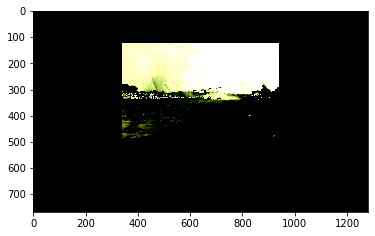

In [4]:
from matplotlib import pyplot as plt

prefix = "FasterRcnn.mindrecord"
mindrecord_dir = config.mindrecord_dir
mindrecord_file = os.path.join(mindrecord_dir, prefix)
file_num = 1
batch_size = 1

if not os.path.exists(mindrecord_file):
    data_to_mindrecord_byte_image(dataset="coco", is_training=True, prefix="FasterRcnn.mindrecord", file_num=file_num)
dataset = create_fasterrcnn_dataset(mindrecord_file, batch_size=batch_size, device_num=1, rank_id=0, num_parallel_workers=1)
print("生成mindrecord数据集文件个数为 {}".format(file_num))
print("文件路径为 {}".format(mindrecord_file))
print("batch size设置为 {}".format(batch_size))
print("第一条数据存储信息的shape如下：")
data = next(dataset.create_dict_iterator())
print("image：{}".format(data["image"].shape))
print("image_shape：{}".format(data["image_shape"].shape))
print("box：{}".format(data["box"].shape))
print("label：{}".format(data["label"].shape))
print("valid_num：{}".format(data["valid_num"].shape))
print("经过数据增强后的数据图片如下：")
plt.imshow(data["image"].asnumpy().transpose(0,2,3,1).squeeze())
plt.show()

### 2.3 模型构建
本案例实现中所构建的Faster-Rcnn模型结构与原论文中的模型有些许不同。原论文中是将一张特征图输入RPN网络中，而本案例中使用了FPN的网络结构，它会输出5张不同尺寸的特征图，并将它们送入RPN网络中。可以清晰的看到该网络对于一副任意大小PxQ的图像：
<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://cdn.jsdelivr.net/gh/Jonydom/myPic/img/Faster-Rcnn结构图.png">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">图2 faster_rcnn网络结构</div>
</center>

首先缩放至固定大小MxN，然后将MxN图像送入ResNet50网络，得到stage1-4的输出特征图；
将4个特征图送入后续的FPN网络，输出为5张特征图；
RPN网络首先经过3x3卷积，再分别生成positive anchors和对应bounding box regression偏移量，然后计算出proposals；
而Roi Pooling层则利用proposals从feature maps中提取proposal feature送入后续全连接和softmax网络作classification（即分类proposal到底是什么object）。

#### 2.3.1 Backbone特征提取网络
本案例中使用的特征提取网络是经典的ResNet50模型。ResNet50模型的backbone部分主要包括5个stage（阶段），其中Stage 0（Input stem）的结构比较简单，可以视其为对INPUT的预处理，后4个Stage都由Bottleneck组成，结构较为相似。Stage 1包含3个Bottleneck，剩下的3个stage分别包括4、6、3个Bottleneck。

ResNet50的网络结构如图3所示。对于一个`shape=(3,224,224)`的输入图片，经过ResNet50网络后会得到`shape=(2048,7,7)`的输出特征图。在本案例中，输入图片的shape为`(3,768,1280)`，经过ResNet50网络得到的输出特征图shape为`(2048,24,40)`。为了使用FPN（Feature pyramid networks）网络，ResNet50的输出结果除了最后一个stage（stage4）的输出特征图外，还包括stage1、stage2、stage3的输出特征图。
<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"  src="https://cdn.jsdelivr.net/gh/Jonydom/myPic/img/constructure.jpeg">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">图3 ResNet50网络结构</div>
</center>

In [5]:
class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        weights_update (bool): Weight update flag.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        False)
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 weights_update=False):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of "
                             "layer_num, inchannel, outchannel list must be 4!")

        bn_training = False
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, pad_mode='pad')
        self.bn1 = nn.BatchNorm2d(64, affine=bn_training, use_batch_statistics=bn_training)
        self.relu = P.ReLU()
        self.maxpool = P.MaxPool(kernel_size=3, strides=2, pad_mode="SAME")
        self.weights_update = weights_update

        if not self.weights_update:
            self.conv1.weight.requires_grad = False

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=1,
                                       training=bn_training,
                                       weights_update=self.weights_update)
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=2,
                                       training=bn_training,
                                       weights_update=True)
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=2,
                                       training=bn_training,
                                       weights_update=True)
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=2,
                                       training=bn_training,
                                       weights_update=True)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride, training=False, weights_update=False):
        """Make block layer."""
        layers = []
        down_sample = False
        if stride != 1 or in_channel != out_channel:
            down_sample = True
        resblk = block(in_channel,
                       out_channel,
                       stride=stride,
                       down_sample=down_sample,
                       training=training,
                       weights_update=weights_update)
        layers.append(resblk)

        for _ in range(1, layer_num):
            resblk = block(out_channel, out_channel, stride=1, training=training, weights_update=weights_update)
            layers.append(resblk)

        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        identity = c2
        if not self.weights_update:
            identity = F.stop_gradient(c2)
        c3 = self.layer2(identity)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        return identity, c3, c4, c5


class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channels (int) - Input channel.
        out_channels (int) - Output channel.
        stride (int) - Stride size for the initial convolutional layer. Default: 1.
        down_sample (bool) - If to do the downsample in block. Default: False.
        momentum (float) - Momentum for batchnorm layer. Default: 0.1.
        training (bool) - Training flag. Default: False.
        weights_updata (bool) - Weights update flag. Default: False.

    Returns:
        Tensor, output tensor.

    Examples:
        ResidualBlock(3,256,stride=2,down_sample=True)
    """
    expansion = 4

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 down_sample=False,
                 momentum=0.1,
                 training=False,
                 weights_update=False):
        super(ResidualBlock, self).__init__()

        self.affine = weights_update

        out_chls = out_channels // self.expansion
        self.conv1 = nn.Conv2d(in_channels, out_chls, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_chls, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        self.conv2 = nn.Conv2d(out_chls, out_chls, kernel_size=3, stride=stride, pad_mode='pad', padding=1)
        self.bn2 = nn.BatchNorm2d(out_chls, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        self.conv3 = nn.Conv2d(out_chls, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        if training:
            self.bn1 = self.bn1.set_train()
            self.bn2 = self.bn2.set_train()
            self.bn3 = self.bn3.set_train()

        if not weights_update:
            self.conv1.weight.requires_grad = False
            self.conv2.weight.requires_grad = False
            self.conv3.weight.requires_grad = False

        self.relu = P.ReLU()
        self.downsample = down_sample
        if self.downsample:
            self.conv_down_sample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
            self.bn_down_sample = nn.BatchNorm2d(out_channels, momentum=momentum, affine=self.affine,
                                                 use_batch_statistics=training)
            if training:
                self.bn_down_sample = self.bn_down_sample.set_train()
            if not weights_update:
                self.conv_down_sample.weight.requires_grad = False
        self.add = P.Add()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample:
            identity = self.conv_down_sample(identity)
            identity = self.bn_down_sample(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out

In [6]:
x = Tensor(np.random.rand(1, 3, 768, 1280), mstype.float32)
resnet = ResNet(ResidualBlock, [3, 4, 6, 3],[64, 256, 512, 1024],[256, 512, 1024, 2048],False)
x = resnet(x)
for i in x:
    print(i.shape)

(1, 256, 192, 320)
(1, 512, 96, 160)
(1, 1024, 48, 80)
(1, 2048, 24, 40)


#### 2.3.2 FPN网络
2017年，Kaiming He等人采用特征金字塔做目标检测，在Faster-Rcnn中backbone骨干网络之后引入FPN（Feature Pyramid Networks），同时利用低层特征高分辨率和高层特征的高语义信息，通过融合这些不同层的特征达到预测的效果。并且预测是在每个融合后的特征层上单独进行的，这和常规的特征融合方式不同。

结构论文地址为
[《Feature Pyramid Networks for Object Detection》](https://arxiv.org/abs/1612.03144)。

FPN网络结构如图4所示。FPN的实现过程：ResNet50中Stage1、Stage2、Stage3、Stage4的输出特征图分别为C2、C3、C4、C5，C5经过1×1的卷积之后得到M5，M5经过上采样和C4结合，得到M4。同理可以得到M3、M2。M2、M3、M4、M5分别经过3×3的卷积得到P2、P3、P4、P5，其中P5再经过下采样得到P6。综上ResNet50的输出结果（C2、C3、C4、C5）送入到FPN网络中会得到五个特征图（P2、P3、P4、P5、P6）。值得一提的是，五个特征图具有相同的通道数，长宽成2倍比例。
<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"  src="https://cdn.jsdelivr.net/gh/Jonydom/myPic/img/FPN网络结构.png">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">图4 FPN网络结构</div>
</center>

In [7]:
import numpy as np
import mindspore as ms
import mindspore.ops as ops
import mindspore.nn as nn
from mindspore.common.tensor import Tensor

class FeatPyramidNeck(nn.Cell):
    """
    Feature pyramid network cell, usually uses as network neck.

    Applies the convolution on multiple, input feature maps
    and output feature map with same channel size. if required num of
    output larger then num of inputs, add extra maxpooling for further
    downsampling;

    Args:
        in_channels (tuple) - Channel size of input feature maps.
        out_channels (int) - Channel size output.
        num_outs (int) - Num of output features.

    Returns:
        Tuple, with tensors of same channel size.

    Examples:
        neck = FeatPyramidNeck([100,200,300], 50, 4, config.feature_shapes)
        input_data = (normal(0,0.1,(1,c,1280//(4*2**i), 768//(4*2**i)),
                      dtype=np.float32) \
                      for i, c in enumerate(config.fpn_in_channels))
        x = neck(input_data)
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 num_outs,
                 feature_shapes):
        super(FeatPyramidNeck, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
        else:
            self.cast_type = mstype.float32

        self.num_outs = num_outs
        self.in_channels = in_channels
        self.fpn_layer = len(self.in_channels)

        assert not self.num_outs < len(in_channels)

        self.lateral_convs_list_ = []
        self.fpn_convs_ = []

        for _, channel in enumerate(in_channels):
            l_conv = nn.Conv2d(channel, out_channels, kernel_size=1, stride=1,
                               padding=0, pad_mode='valid').to_float(self.cast_type)
            fpn_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                                 padding=0, pad_mode='same').to_float(self.cast_type)
            self.lateral_convs_list_.append(l_conv)
            self.fpn_convs_.append(fpn_conv)
        self.lateral_convs_list = nn.layer.CellList(self.lateral_convs_list_)
        self.fpn_convs_list = nn.layer.CellList(self.fpn_convs_)
        self.interpolate1 = P.ResizeBilinear(feature_shapes[2])
        self.interpolate2 = P.ResizeBilinear(feature_shapes[1])
        self.interpolate3 = P.ResizeBilinear(feature_shapes[0])
        self.cast = P.Cast()
        self.maxpool = P.MaxPool(kernel_size=1, strides=2, pad_mode="same")

    def construct(self, inputs):
        x = ()
        for i in range(self.fpn_layer):
            x += (self.lateral_convs_list[i](inputs[i]),)

        y = (x[3],)
        y = y + (x[2] + self.cast(self.interpolate1(y[self.fpn_layer - 4]), self.cast_type),)
        y = y + (x[1] + self.cast(self.interpolate2(y[self.fpn_layer - 3]), self.cast_type),)
        y = y + (x[0] + self.cast(self.interpolate3(y[self.fpn_layer - 2]), self.cast_type),)

        z = ()
        for i in range(self.fpn_layer - 1, -1, -1):
            z = z + (y[i],)

        outs = ()
        for i in range(self.fpn_layer):
            outs = outs + (self.fpn_convs_list[i](z[i]),)

        for i in range(self.num_outs - self.fpn_layer):
            outs = outs + (self.maxpool(outs[3]),)
        return outs

In [8]:
resnet = ResNet(ResidualBlock, [3, 4, 6, 3],[64, 256, 512, 1024],[256, 512, 1024, 2048],False)
x = Tensor(np.random.rand(1, 3, 768, 1280), mstype.float32)
x = resnet(x)

neck = FeatPyramidNeck([256, 512, 1024, 2048], 256, 5, config.feature_shapes)
res = neck(x)
for i in range(len(res)):
    print(res[i].shape)

(1, 256, 192, 320)
(1, 256, 96, 160)
(1, 256, 48, 80)
(1, 256, 24, 40)
(1, 256, 12, 20)


#### 2.3.3 anchor生成
在Faster-RCNN网络的RPN阶段中，需要根据backbone网络抽取的feature map的大小，对每个点生成相应的anchor。所谓anchor，实际上就是一组矩形框，它们的大小、尺寸、位置坐标由base_size、scales、ratios和featmap_size决定。对于一个由ResNet50提取的特征图feature map，生成anchor的大致流程如下：
1) 首先有个base_size，指定生成的基础anchor的大小，生成的基础anchor的长和宽都是base_size，这时候只有一个anchor；

2) 以base_size的大小为基础，按照三种长宽比ratios{2:1, 1:1, 1:2}，生成指定长宽比的基础anchor；

3) 根据指定的缩放比例，对基础anchor进行缩放，本案例中缩放比例一共有1种，缩放比例为8，三种长宽比和一种缩放比例，就得到了3 * 1 = 3个基础anchor；

4) 上面的过程描述了特征上一个cell对应的anchor的生成过程，对于特征图上的每个cell，都要生成3个anchor。在本案例中，提供了一个stride参数，用于将在feature map上生成的anchor尺寸还原为原图中的anchor尺寸。

In [9]:
import numpy as np
class AnchorGenerator():
    def __init__(self, base_size, scales, ratios):
        self.base_size = base_size
        self.scales = np.array(scales)
        self.ratios = np.array(ratios)
        self.base_anchors = self.gen_base_anchors()
    def gen_base_anchors(self):
        # 生成feather map中一个点的anchors
        w = self.base_size
        h = self.base_size
        x_ctr = 0.5 * (w - 1)
        y_ctr = 0.5 * (h - 1)
        h_ratios = np.sqrt(self.ratios)
        w_ratios = 1 / h_ratios
        ws = (w * w_ratios[:, None] * self.scales[None, :]).reshape(-1)
        hs = (h * h_ratios[:, None] * self.scales[None, :]).reshape(-1)
        base_anchors = np.stack([
            x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
            x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
        ], axis=-1).round()
        return base_anchors
    def _meshgrid(self, x, y, row_major=True):
        xx = np.repeat(x.reshape(1, len(x)), len(y), axis=0).reshape(-1)
        yy = np.repeat(y, len(x))
        if row_major:
            return xx, yy
        return yy, xx
    def grid_anchors(self, featmap_size, stride=16):
        # 根据feature map的大小，生成对应的所有anchors
        base_anchors = self.base_anchors
        
        feat_h, feat_w = featmap_size
        shift_x = np.arange(0, feat_w) * stride
        shift_y = np.arange(0, feat_h) * stride
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        shifts = np.stack([shift_xx, shift_yy, shift_xx, shift_yy], axis=-1)
        shifts = shifts.astype(base_anchors.dtype)
        all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
        all_anchors = all_anchors.reshape(-1, 4)
        
        return all_anchors

In [10]:
base_size = 4
scales = [8]
ratios = [0.5, 1.0, 2.0]
featmap_size = [192, 320]
stride = 4
x = AnchorGenerator(base_size, scales, ratios)
all_anchors = x.grid_anchors(featmap_size, stride)
print(f"For {featmap_size[0]}*{featmap_size[1]} feature map, the number of generated anchors is {len(all_anchors)}.")
print(f"Generated anchors as follow:")
print(all_anchors)

For 192*320 feature map, the number of generated anchors is 184320.
Generated anchors as follow:
[[ -21.   -9.   24.   12.]
 [ -14.  -14.   17.   17.]
 [  -9.  -21.   12.   24.]
 ...
 [1255.  755. 1300.  776.]
 [1262.  750. 1293.  781.]
 [1267.  743. 1288.  788.]]


#### 2.3.4 RPN
BboxAssignSample为RPN的子模块，由于目标检测的特点是负样本数量远大于正样本数量，因此需要通过BboxAssignSample平衡正负样本进行随机采样。BboxAssignSample为RPN模块选择固定比率的正负样本参与loss计算；

RPN的作用是用来判断每个像素点对应的k个（9个）anchor box区域是否包含目标。RPN网络有用于box的回归（reg layer）和分类(cls layer)的两个分支，分别实现对anchor进行回归偏移（位置及尺寸修正）和分类（二分类，判断是否包含object），以此来确定最终的候选区域（region proposal）；

**cls layer**：将特征图上每个点的 256 维特征与cls layer全连接层连接，使用softmax loss实现分类。它的输出为 2 * 9 个值，为这个锚点对应的 9 个 achor box，与每个box的两个值分别表示包含目标的概率与不包含的概率。

**reg layer**：reg layer全连接层输出4 * 9个值，每个 anchor box 对应4个值，它们分别表示对 groud truth 的长宽与x、y坐标的预测。训练时只有包含目标（groud truth IoU>0.7）的anchor box。


In [11]:
class BboxAssignSample(nn.Cell):
    """
    为RPN模块的子模块，为RPN选择固定比率的正负样本参与loss计算
    Bbox assigner and sampler definition.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_bboxes (int): The anchor nums.
        add_gt_as_proposals (bool): add gt bboxes as proposals flag.

    Returns:
        Tensor, output tensor.
        bbox_targets: bbox location, (batch_size, num_bboxes, 4)
        bbox_weights: bbox weights, (batch_size, num_bboxes, 1)
        labels: label for every bboxes, (batch_size, num_bboxes, 1)
        label_weights: label weight for every bboxes, (batch_size, num_bboxes, 1)

    Examples:
        BboxAssignSample(config, 2, 1024, True)
    """

    def __init__(self, config, batch_size, num_bboxes, add_gt_as_proposals):
        super(BboxAssignSample, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.batch_size = batch_size

        self.neg_iou_thr = Tensor(cfg.neg_iou_thr, self.cast_type)
        self.pos_iou_thr = Tensor(cfg.pos_iou_thr, self.cast_type)
        self.min_pos_iou = Tensor(cfg.min_pos_iou, self.cast_type)
        self.zero_thr = Tensor(0.0, self.cast_type)

        self.num_bboxes = num_bboxes
        self.num_gts = cfg.num_gts
        self.num_expected_pos = cfg.num_expected_pos
        self.num_expected_neg = cfg.num_expected_neg
        self.add_gt_as_proposals = add_gt_as_proposals

        if self.add_gt_as_proposals:
            self.label_inds = Tensor(np.arange(1, self.num_gts + 1))

        self.concat = P.Concat(axis=0)
        self.max_gt = P.ArgMaxWithValue(axis=0)
        self.max_anchor = P.ArgMaxWithValue(axis=1)
        self.sum_inds = P.ReduceSum()
        self.iou = P.IOU()
        self.greaterequal = P.GreaterEqual()
        self.greater = P.Greater()
        self.select = P.Select()
        self.gatherND = P.GatherNd()
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()
        self.logicaland = P.LogicalAnd()
        self.less = P.Less()
        self.random_choice_with_mask_pos = P.RandomChoiceWithMask(self.num_expected_pos)
        self.random_choice_with_mask_neg = P.RandomChoiceWithMask(self.num_expected_neg)
        self.reshape = P.Reshape()
        self.equal = P.Equal()
        self.bounding_box_encode = P.BoundingBoxEncode(means=(0.0, 0.0, 0.0, 0.0), stds=(1.0, 1.0, 1.0, 1.0))
        self.scatterNdUpdate = P.ScatterNdUpdate()
        self.scatterNd = P.ScatterNd()
        self.logicalnot = P.LogicalNot()
        self.tile = P.Tile()
        self.zeros_like = P.ZerosLike()

        self.assigned_gt_inds = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_zeros = Tensor(np.array(np.zeros(num_bboxes), dtype=np.int32))
        self.assigned_gt_ones = Tensor(np.array(np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_ignores = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_pos_ones = Tensor(np.array(np.ones(self.num_expected_pos), dtype=np.int32))

        self.check_neg_mask = Tensor(np.array(np.ones(self.num_expected_neg - self.num_expected_pos), dtype=bool))
        self.range_pos_size = Tensor(np.arange(self.num_expected_pos).astype(self.np_cast_type))
        self.check_gt_one = Tensor(np.array(-1 * np.ones((self.num_gts, 4)), dtype=self.np_cast_type))
        self.check_anchor_two = Tensor(np.array(-2 * np.ones((self.num_bboxes, 4)), dtype=self.np_cast_type))

    def construct(self, gt_bboxes_i, gt_labels_i, valid_mask, bboxes, gt_valids):
        gt_bboxes_i = self.select(self.cast(self.tile(self.reshape(self.cast(gt_valids, mstype.int32), \
                                                                   (self.num_gts, 1)), (1, 4)), mstype.bool_),
                                  gt_bboxes_i, self.check_gt_one)
        bboxes = self.select(self.cast(self.tile(self.reshape(self.cast(valid_mask, mstype.int32), \
                                                              (self.num_bboxes, 1)), (1, 4)), mstype.bool_), bboxes,
                             self.check_anchor_two)

        overlaps = self.iou(bboxes, gt_bboxes_i)

        max_overlaps_w_gt_index, max_overlaps_w_gt = self.max_gt(overlaps)
        _, max_overlaps_w_ac = self.max_anchor(overlaps)

        neg_sample_iou_mask = self.logicaland(self.greaterequal(max_overlaps_w_gt, self.zero_thr), \
                                              self.less(max_overlaps_w_gt, self.neg_iou_thr))
        assigned_gt_inds2 = self.select(neg_sample_iou_mask, self.assigned_gt_zeros, self.assigned_gt_inds)

        pos_sample_iou_mask = self.greaterequal(max_overlaps_w_gt, self.pos_iou_thr)
        assigned_gt_inds3 = self.select(pos_sample_iou_mask, \
                                        max_overlaps_w_gt_index + self.assigned_gt_ones, assigned_gt_inds2)
        assigned_gt_inds4 = assigned_gt_inds3
        for j in range(self.num_gts):
            max_overlaps_w_ac_j = max_overlaps_w_ac[j:j + 1:1]
            overlaps_w_gt_j = self.squeeze(overlaps[j:j + 1:1, ::])

            pos_mask_j = self.logicaland(self.greaterequal(max_overlaps_w_ac_j, self.min_pos_iou), \
                                         self.equal(overlaps_w_gt_j, max_overlaps_w_ac_j))

            assigned_gt_inds4 = self.select(pos_mask_j, self.assigned_gt_ones + j, assigned_gt_inds4)

        assigned_gt_inds5 = self.select(valid_mask, assigned_gt_inds4, self.assigned_gt_ignores)

        pos_index, valid_pos_index = self.random_choice_with_mask_pos(self.greater(assigned_gt_inds5, 0))

        pos_check_valid = self.cast(self.greater(assigned_gt_inds5, 0), self.cast_type)
        pos_check_valid = self.sum_inds(pos_check_valid, -1)
        valid_pos_index = self.less(self.range_pos_size, pos_check_valid)
        pos_index = pos_index * self.reshape(self.cast(valid_pos_index, mstype.int32), (self.num_expected_pos, 1))

        pos_assigned_gt_index = self.gatherND(assigned_gt_inds5, pos_index) - self.assigned_pos_ones
        pos_assigned_gt_index = pos_assigned_gt_index * self.cast(valid_pos_index, mstype.int32)
        pos_assigned_gt_index = self.reshape(pos_assigned_gt_index, (self.num_expected_pos, 1))

        neg_index, valid_neg_index = self.random_choice_with_mask_neg(self.equal(assigned_gt_inds5, 0))

        num_pos = self.cast(self.logicalnot(valid_pos_index), self.cast_type)
        num_pos = self.sum_inds(num_pos, -1)
        unvalid_pos_index = self.less(self.range_pos_size, num_pos)
        valid_neg_index = self.logicaland(self.concat((self.check_neg_mask, unvalid_pos_index)), valid_neg_index)

        pos_bboxes_ = self.gatherND(bboxes, pos_index)
        pos_gt_bboxes_ = self.gatherND(gt_bboxes_i, pos_assigned_gt_index)
        pos_gt_labels = self.gatherND(gt_labels_i, pos_assigned_gt_index)

        pos_bbox_targets_ = self.bounding_box_encode(pos_bboxes_, pos_gt_bboxes_)

        valid_pos_index = self.cast(valid_pos_index, mstype.int32)
        valid_neg_index = self.cast(valid_neg_index, mstype.int32)
        bbox_targets_total = self.scatterNd(pos_index, pos_bbox_targets_, (self.num_bboxes, 4))
        bbox_weights_total = self.scatterNd(pos_index, valid_pos_index, (self.num_bboxes,))
        labels_total = self.scatterNd(pos_index, pos_gt_labels, (self.num_bboxes,))
        total_index = self.concat((pos_index, neg_index))
        total_valid_index = self.concat((valid_pos_index, valid_neg_index))
        label_weights_total = self.scatterNd(total_index, total_valid_index, (self.num_bboxes,))

        return bbox_targets_total, self.cast(bbox_weights_total, mstype.bool_), \
               labels_total, self.cast(label_weights_total, mstype.bool_)

class RpnRegClsBlock(nn.Cell):
    """
    Rpn reg cls block for rpn layer

    Args:
        in_channels (int) - Input channels of shared convolution.
        feat_channels (int) - Output channels of shared convolution.
        num_anchors (int) - The anchor number.
        cls_out_channels (int) - Output channels of classification convolution.
        weight_conv (Tensor) - weight init for rpn conv.
        bias_conv (Tensor) - bias init for rpn conv.
        weight_cls (Tensor) - weight init for rpn cls conv.
        bias_cls (Tensor) - bias init for rpn cls conv.
        weight_reg (Tensor) - weight init for rpn reg conv.
        bias_reg (Tensor) - bias init for rpn reg conv.

    Returns:
        Tensor, output tensor.
    """

    def __init__(self,
                 in_channels,
                 feat_channels,
                 num_anchors,
                 cls_out_channels,
                 weight_conv,
                 bias_conv,
                 weight_cls,
                 bias_cls,
                 weight_reg,
                 bias_reg):
        super(RpnRegClsBlock, self).__init__()
        self.rpn_conv = nn.Conv2d(in_channels, feat_channels, kernel_size=3, stride=1, pad_mode='same',
                                  has_bias=True, weight_init=weight_conv, bias_init=bias_conv)
        self.relu = nn.ReLU()

        self.rpn_cls = nn.Conv2d(feat_channels, num_anchors * cls_out_channels, kernel_size=1, pad_mode='valid',
                                 has_bias=True, weight_init=weight_cls, bias_init=bias_cls)
        self.rpn_reg = nn.Conv2d(feat_channels, num_anchors * 4, kernel_size=1, pad_mode='valid',
                                 has_bias=True, weight_init=weight_reg, bias_init=bias_reg)

    def construct(self, x):
        x = self.relu(self.rpn_conv(x))

        x1 = self.rpn_cls(x)
        x2 = self.rpn_reg(x)

        return x1, x2

class RPN(nn.Cell):
    """
    ROI proposal network..

    Args:
        config (dict) - Config.
        batch_size (int) - Batchsize.
        in_channels (int) - Input channels of shared convolution.
        feat_channels (int) - Output channels of shared convolution.
        num_anchors (int) - The anchor number.
        cls_out_channels (int) - Output channels of classification convolution.

    Returns:
        Tuple, tuple of output tensor.

    Examples:
        RPN(config=config, batch_size=2, in_channels=256, feat_channels=1024,
            num_anchors=3, cls_out_channels=512)
    """
    def __init__(self,
                 config,
                 batch_size,
                 in_channels,
                 feat_channels,
                 num_anchors,
                 cls_out_channels):
        super(RPN, self).__init__()
        cfg_rpn = config
        if context.get_context("device_target") == "CPU" or context.get_context("device_target") == "GPU":
            self.platform_dtype = np.float32
            self.platform_mstype = mstype.float32
        else:
            self.platform_dtype = np.float32
            self.platform_mstype = mstype.float32
        self.num_bboxes = cfg_rpn.num_bboxes
        self.slice_index = ()
        self.feature_anchor_shape = ()
        self.slice_index += (0,)
        index = 0
        for shape in cfg_rpn.feature_shapes:
            self.slice_index += (self.slice_index[index] + shape[0] * shape[1] * num_anchors,)
            self.feature_anchor_shape += (shape[0] * shape[1] * num_anchors * batch_size,)
            index += 1

        self.num_anchors = num_anchors
        self.batch_size = batch_size
        self.test_batch_size = cfg_rpn.test_batch_size
        self.num_layers = 5
        self.real_ratio = Tensor(np.ones((1, 1)).astype(self.platform_dtype))

        self.rpn_convs_list = nn.layer.CellList(self._make_rpn_layer(self.num_layers, in_channels, feat_channels,
                                                                     num_anchors, cls_out_channels))

        self.transpose = P.Transpose()
        self.reshape = P.Reshape()
        self.concat = P.Concat(axis=0)
        self.fill = P.Fill()
        self.placeh1 = Tensor(np.ones((1,)).astype(self.platform_dtype))

        self.trans_shape = (0, 2, 3, 1)

        self.reshape_shape_reg = (-1, 4)
        self.reshape_shape_cls = (-1,)
        self.rpn_loss_reg_weight = Tensor(np.array(cfg_rpn.rpn_loss_reg_weight).astype(self.platform_dtype)) # 1.0
        self.rpn_loss_cls_weight = Tensor(np.array(cfg_rpn.rpn_loss_cls_weight).astype(self.platform_dtype)) # 1.0
        self.num_expected_total = Tensor(np.array(cfg_rpn.num_expected_neg * \
                                                  self.batch_size).astype(self.platform_dtype))
        self.num_bboxes = cfg_rpn.num_bboxes
        self.get_targets = BboxAssignSample(cfg_rpn, self.batch_size, self.num_bboxes, False)
        self.CheckValid = P.CheckValid()
        self.sum_loss = P.ReduceSum()  # 输出Tensor各维度上的和
        self.loss_cls = P.SigmoidCrossEntropyWithLogits()
        self.loss_bbox = P.SmoothL1Loss(beta=1.0/9.0)
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()
        self.tile = P.Tile()
        self.zeros_like = P.ZerosLike()
        self.loss = Tensor(np.zeros((1,)).astype(self.platform_dtype))
        self.clsloss = Tensor(np.zeros((1,)).astype(self.platform_dtype))
        self.regloss = Tensor(np.zeros((1,)).astype(self.platform_dtype))

    def _make_rpn_layer(self, num_layers, in_channels, feat_channels, num_anchors, cls_out_channels):
        """
        make rpn layer for rpn proposal network

        Args:
        num_layers (int) - layer num.
        in_channels (int) - Input channels of shared convolution.
        feat_channels (int) - Output channels of shared convolution.
        num_anchors (int) - The anchor number.
        cls_out_channels (int) - Output channels of classification convolution.

        Returns:
        List, list of RpnRegClsBlock cells.
        """
        rpn_layer = []

        shp_weight_conv = (feat_channels, in_channels, 3, 3)
        shp_bias_conv = (feat_channels,)
        weight_conv = initializer('Normal', shape=shp_weight_conv, dtype=mstype.float32)
        bias_conv = initializer(0, shape=shp_bias_conv, dtype=mstype.float32)

        shp_weight_cls = (num_anchors * cls_out_channels, feat_channels, 1, 1)
        shp_bias_cls = (num_anchors * cls_out_channels,)
        weight_cls = initializer('Normal', shape=shp_weight_cls, dtype=mstype.float32)
        bias_cls = initializer(0, shape=shp_bias_cls, dtype=mstype.float32)

        shp_weight_reg = (num_anchors * 4, feat_channels, 1, 1)
        shp_bias_reg = (num_anchors * 4,)
        weight_reg = initializer('Normal', shape=shp_weight_reg, dtype=mstype.float32)
        bias_reg = initializer(0, shape=shp_bias_reg, dtype=mstype.float32)

        for i in range(num_layers):
            rpn_layer.append(RpnRegClsBlock(in_channels, feat_channels, num_anchors, cls_out_channels, \
                                            weight_conv, bias_conv, weight_cls, \
                                            bias_cls, weight_reg, bias_reg).to_float(self.platform_mstype))

        for i in range(1, num_layers):
            rpn_layer[i].rpn_conv.weight = rpn_layer[0].rpn_conv.weight
            rpn_layer[i].rpn_cls.weight = rpn_layer[0].rpn_cls.weight
            rpn_layer[i].rpn_reg.weight = rpn_layer[0].rpn_reg.weight

            rpn_layer[i].rpn_conv.bias = rpn_layer[0].rpn_conv.bias
            rpn_layer[i].rpn_cls.bias = rpn_layer[0].rpn_cls.bias
            rpn_layer[i].rpn_reg.bias = rpn_layer[0].rpn_reg.bias

        return rpn_layer

    def construct(self, inputs, img_metas, anchor_list, gt_bboxes, gt_labels, gt_valids):
        loss_print = ()
        rpn_cls_score = ()
        rpn_bbox_pred = ()
        rpn_cls_score_total = ()
        rpn_bbox_pred_total = ()

        for i in range(self.num_layers):
            x1, x2 = self.rpn_convs_list[i](inputs[i])

            rpn_cls_score_total = rpn_cls_score_total + (x1,)
            rpn_bbox_pred_total = rpn_bbox_pred_total + (x2,)

            x1 = self.transpose(x1, self.trans_shape)  # (0,2,3,1)
            x1 = self.reshape(x1, self.reshape_shape_cls) # (-1,)

            x2 = self.transpose(x2, self.trans_shape)
            x2 = self.reshape(x2, self.reshape_shape_reg) # (-1,4)

            rpn_cls_score = rpn_cls_score + (x1,)
            rpn_bbox_pred = rpn_bbox_pred + (x2,)

        loss = self.loss  # Tensor(1.0)
        clsloss = self.clsloss
        regloss = self.regloss
        bbox_targets = ()
        bbox_weights = ()
        labels = ()
        label_weights = ()

        output = ()
        if self.training:
            for i in range(self.batch_size):
                multi_level_flags = ()
                anchor_list_tuple = ()

                for j in range(self.num_layers):
                    res = self.cast(self.CheckValid(anchor_list[j], self.squeeze(img_metas[i:i + 1, ::])),
                                    mstype.int32)
                    multi_level_flags = multi_level_flags + (res,)
                    anchor_list_tuple = anchor_list_tuple + (anchor_list[j],)

                valid_flag_list = self.concat(multi_level_flags)
                anchor_using_list = self.concat(anchor_list_tuple) # 在默认维度上拼接

                gt_bboxes_i = self.squeeze(gt_bboxes[i:i + 1:1, ::])
                gt_labels_i = self.squeeze(gt_labels[i:i + 1:1, ::])
                gt_valids_i = self.squeeze(gt_valids[i:i + 1:1, ::])

                bbox_target, bbox_weight, label, label_weight = self.get_targets(gt_bboxes_i,
                                                                                 gt_labels_i,
                                                                                 self.cast(valid_flag_list,
                                                                                           mstype.bool_),
                                                                                 anchor_using_list, gt_valids_i)

                bbox_weight = self.cast(bbox_weight, self.platform_mstype)
                label = self.cast(label, self.platform_mstype)
                label_weight = self.cast(label_weight, self.platform_mstype)

                for j in range(self.num_layers):
                    begin = self.slice_index[j]
                    end = self.slice_index[j + 1]
                    stride = 1
                    bbox_targets += (bbox_target[begin:end:stride, ::],)
                    bbox_weights += (bbox_weight[begin:end:stride],)
                    labels += (label[begin:end:stride],)
                    label_weights += (label_weight[begin:end:stride],)

            for i in range(self.num_layers):
                bbox_target_using = ()
                bbox_weight_using = ()
                label_using = ()
                label_weight_using = ()

                for j in range(self.batch_size):
                    bbox_target_using += (bbox_targets[i + (self.num_layers * j)],)
                    bbox_weight_using += (bbox_weights[i + (self.num_layers * j)],)
                    label_using += (labels[i + (self.num_layers * j)],)
                    label_weight_using += (label_weights[i + (self.num_layers * j)],)

                bbox_target_with_batchsize = self.concat(bbox_target_using)
                bbox_weight_with_batchsize = self.concat(bbox_weight_using)
                label_with_batchsize = self.concat(label_using)
                label_weight_with_batchsize = self.concat(label_weight_using)

                # stop
                bbox_target_ = F.stop_gradient(bbox_target_with_batchsize)
                bbox_weight_ = F.stop_gradient(bbox_weight_with_batchsize)
                label_ = F.stop_gradient(label_with_batchsize)
                label_weight_ = F.stop_gradient(label_weight_with_batchsize)

                cls_score_i = rpn_cls_score[i]
                reg_score_i = rpn_bbox_pred[i]

                loss_cls = self.loss_cls(cls_score_i, label_)
                loss_cls_item = loss_cls * label_weight_
                loss_cls_item = self.sum_loss(loss_cls_item, (0,)) / self.num_expected_total

                loss_reg = self.loss_bbox(reg_score_i, bbox_target_)
                bbox_weight_ = self.tile(self.reshape(bbox_weight_, (self.feature_anchor_shape[i], 1)), (1, 4))
                loss_reg = loss_reg * bbox_weight_
                loss_reg_item = self.sum_loss(loss_reg, (1,))
                loss_reg_item = self.sum_loss(loss_reg_item, (0,)) / self.num_expected_total

                loss_total = self.rpn_loss_cls_weight * loss_cls_item + self.rpn_loss_reg_weight * loss_reg_item

                loss += loss_total
                loss_print += (loss_total, loss_cls_item, loss_reg_item)
                clsloss += loss_cls_item
                regloss += loss_reg_item

                output = (loss, rpn_cls_score_total, rpn_bbox_pred_total, clsloss, regloss, loss_print)
        else:
            output = (self.placeh1, rpn_cls_score_total, rpn_bbox_pred_total, self.placeh1, self.placeh1, self.placeh1)

        return output

#### 2.3.5 Proposal
Proposal层负责对RPN的reg layer、cls layer两个分支结果进行汇总，来实现对anchor的初步筛除。Proposal层输入有anchors分类结果（positive与negative的得分情况）；reg layer得到的偏移量（d_x,d_y,d_w,d_h）；以及anchor_list；

Proposal层处理步骤如下：  
（1）按照positive 相对应的softmax score进行排序，提取2000个anchors，得到修正位置后的positive anchors。

（2）限定超出图像边界的positive anchors为图像边界，防止后续roi pooling时proposal超出图像边界，剔除小尺寸的anchors

（3）一个物体可能会有多个Anchors重叠对应，所以对剩余的positive anchors进行NMS（nonmaximum suppression）筛选

（4）最后剩余的对应的bbox reg的偏移量结果进行回归计算，作为proposal输出，获取最终精准的proposals定位。

In [12]:
class Proposal(nn.Cell):
    """
    Proposal subnet.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_classes (int) - Class number.
        use_sigmoid_cls (bool) - Select sigmoid or softmax function.
        target_means (tuple) - Means for encode function. Default: (.0, .0, .0, .0).
        target_stds (tuple) - Stds for encode function. Default: (1.0, 1.0, 1.0, 1.0).

    Returns:
        Tuple, tuple of output tensor,(proposal, mask).

    Examples:
        Proposal(config = config, batch_size = 1, num_classes = 81, use_sigmoid_cls = True, \
                 target_means=(.0, .0, .0, .0), target_stds=(1.0, 1.0, 1.0, 1.0))
    """

    def __init__(self,
                 config,
                 batch_size,
                 num_classes,
                 use_sigmoid_cls,
                 target_means=(.0, .0, .0, .0),
                 target_stds=(1.0, 1.0, 1.0, 1.0)
                 ):
        super(Proposal, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.target_means = target_means
        self.target_stds = target_stds
        self.use_sigmoid_cls = use_sigmoid_cls
        self.reshape_shape = (-1, 1)

        if self.use_sigmoid_cls:
            self.cls_out_channels = num_classes - 1
            self.activation = P.Sigmoid()
        else:
            self.cls_out_channels = num_classes
            self.activation = P.Softmax(axis=1)

        if self.cls_out_channels <= 0:
            raise ValueError('num_classes={} is too small'.format(num_classes))

        self.num_pre = cfg.rpn_proposal_nms_pre
        self.min_box_size = cfg.rpn_proposal_min_bbox_size
        self.nms_thr = cfg.rpn_proposal_nms_thr
        self.nms_post = cfg.rpn_proposal_nms_post
        self.nms_across_levels = cfg.rpn_proposal_nms_across_levels
        self.max_num = cfg.rpn_proposal_max_num
        self.num_levels = cfg.fpn_num_outs

        # Op Define
        self.squeeze = P.Squeeze()
        self.reshape = P.Reshape()
        self.cast = P.Cast()

        self.feature_shapes = cfg.feature_shapes

        self.transpose_shape = (1, 2, 0)

        self.decode = P.BoundingBoxDecode(max_shape=(cfg.img_height, cfg.img_width), \
                                          means=self.target_means, \
                                          stds=self.target_stds)

        self.nms = P.NMSWithMask(self.nms_thr)
        self.concat_axis0 = P.Concat(axis=0)
        self.concat_axis1 = P.Concat(axis=1)
        self.split = P.Split(axis=1, output_num=5)
        self.min = P.Minimum()
        self.gatherND = P.GatherNd()
        self.slice = P.Slice()
        self.select = P.Select()
        self.greater = P.Greater()
        self.transpose = P.Transpose()
        self.tile = P.Tile()
        self.set_train_local(config, training=True)

        self.multi_10 = Tensor(10.0, self.cast_type)

    def set_train_local(self, config, training=True):
        """Set training flag."""
        self.training_local = training

        cfg = config
        self.topK_stage1 = ()
        self.topK_shape = ()
        total_max_topk_input = 0
        if not self.training_local:
            self.num_pre = cfg.rpn_nms_pre
            self.min_box_size = cfg.rpn_min_bbox_min_size
            self.nms_thr = cfg.rpn_nms_thr
            self.nms_post = cfg.rpn_nms_post
            self.nms_across_levels = cfg.rpn_nms_across_levels
            self.max_num = cfg.rpn_max_num

        for shp in self.feature_shapes:
            k_num = min(self.num_pre, (shp[0] * shp[1] * 3))
            total_max_topk_input += k_num
            self.topK_stage1 += (k_num,)
            self.topK_shape += ((k_num, 1),)

        self.topKv2 = P.TopK(sorted=True)
        self.topK_shape_stage2 = (self.max_num, 1)
        self.min_float_num = -65536.0
        self.topK_mask = Tensor(self.min_float_num * np.ones(total_max_topk_input, self.np_cast_type))

    def construct(self, rpn_cls_score_total, rpn_bbox_pred_total, anchor_list):
        proposals_tuple = ()
        masks_tuple = ()
        for img_id in range(self.batch_size):
            cls_score_list = ()
            bbox_pred_list = ()
            for i in range(self.num_levels):
                rpn_cls_score_i = self.squeeze(rpn_cls_score_total[i][img_id:img_id + 1:1, ::, ::, ::])
                rpn_bbox_pred_i = self.squeeze(rpn_bbox_pred_total[i][img_id:img_id + 1:1, ::, ::, ::])

                cls_score_list = cls_score_list + (rpn_cls_score_i,)
                bbox_pred_list = bbox_pred_list + (rpn_bbox_pred_i,)

            proposals, masks = self.get_bboxes_single(cls_score_list, bbox_pred_list, anchor_list)
            proposals_tuple += (proposals,)
            masks_tuple += (masks,)
        return proposals_tuple, masks_tuple

    def get_bboxes_single(self, cls_scores, bbox_preds, mlvl_anchors):
        """Get proposal boundingbox."""
        mlvl_proposals = ()
        mlvl_mask = ()
        for idx in range(self.num_levels):
            rpn_cls_score = self.transpose(cls_scores[idx], self.transpose_shape)
            rpn_bbox_pred = self.transpose(bbox_preds[idx], self.transpose_shape)
            anchors = mlvl_anchors[idx]

            rpn_cls_score = self.reshape(rpn_cls_score, self.reshape_shape)
            rpn_cls_score = self.activation(rpn_cls_score)
            rpn_cls_score_process = self.cast(self.squeeze(rpn_cls_score[::, 0::]), self.cast_type)

            rpn_bbox_pred_process = self.cast(self.reshape(rpn_bbox_pred, (-1, 4)), self.cast_type)

            scores_sorted, topk_inds = self.topKv2(rpn_cls_score_process, self.topK_stage1[idx])

            topk_inds = self.reshape(topk_inds, self.topK_shape[idx])

            bboxes_sorted = self.gatherND(rpn_bbox_pred_process, topk_inds)
            anchors_sorted = self.cast(self.gatherND(anchors, topk_inds), self.cast_type)

            proposals_decode = self.decode(anchors_sorted, bboxes_sorted)

            proposals_decode = self.concat_axis1((proposals_decode, self.reshape(scores_sorted, self.topK_shape[idx])))
            proposals, _, mask_valid = self.nms(proposals_decode)

            mlvl_proposals = mlvl_proposals + (proposals,)
            mlvl_mask = mlvl_mask + (mask_valid,)

        proposals = self.concat_axis0(mlvl_proposals)
        masks = self.concat_axis0(mlvl_mask)

        _, _, _, _, scores = self.split(proposals)
        scores = self.squeeze(scores)
        topk_mask = self.cast(self.topK_mask, self.cast_type)
        scores_using = self.select(masks, scores, topk_mask)

        _, topk_inds = self.topKv2(scores_using, self.max_num)

        topk_inds = self.reshape(topk_inds, self.topK_shape_stage2)
        proposals = self.gatherND(proposals, topk_inds)
        masks = self.gatherND(masks, topk_inds)
        return proposals, masks

#### 2.3.6 Assign and sampler stage two

In [13]:
class BboxAssignSampleForRcnn(nn.Cell):
    """
    Bbox assigner and sampler definition.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_bboxes (int): The anchor nums.
        add_gt_as_proposals (bool): add gt bboxes as proposals flag.

    Returns:
        Tensor, output tensor.
        bbox_targets: bbox location, (batch_size, num_bboxes, 4)
        bbox_weights: bbox weights, (batch_size, num_bboxes, 1)
        labels: label for every bboxes, (batch_size, num_bboxes, 1)
        label_weights: label weight for every bboxes, (batch_size, num_bboxes, 1)

    Examples:
        BboxAssignSampleForRcnn(config, 2, 1024, True)
    """

    def __init__(self, config, batch_size, num_bboxes, add_gt_as_proposals):
        super(BboxAssignSampleForRcnn, self).__init__()
        cfg = config
        
        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        
        self.batch_size = batch_size
        self.neg_iou_thr = cfg.neg_iou_thr_stage2
        self.pos_iou_thr = cfg.pos_iou_thr_stage2
        self.min_pos_iou = cfg.min_pos_iou_stage2
        self.num_gts = cfg.num_gts
        self.num_bboxes = num_bboxes
        self.num_expected_pos = cfg.num_expected_pos_stage2
        self.num_expected_neg = cfg.num_expected_neg_stage2
        self.num_expected_total = cfg.num_expected_total_stage2

        self.add_gt_as_proposals = add_gt_as_proposals
        self.label_inds = Tensor(np.arange(1, self.num_gts + 1).astype(np.int32))
        self.add_gt_as_proposals_valid = Tensor(np.array(self.add_gt_as_proposals * np.ones(self.num_gts),
                                                         dtype=np.int32))

        self.concat = P.Concat(axis=0)
        self.max_gt = P.ArgMaxWithValue(axis=0)
        self.max_anchor = P.ArgMaxWithValue(axis=1)
        self.sum_inds = P.ReduceSum()
        self.iou = P.IOU()
        self.greaterequal = P.GreaterEqual()
        self.greater = P.Greater()
        self.select = P.Select()
        self.gatherND = P.GatherNd()
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()
        self.logicaland = P.LogicalAnd()
        self.less = P.Less()
        self.random_choice_with_mask_pos = P.RandomChoiceWithMask(self.num_expected_pos)
        self.random_choice_with_mask_neg = P.RandomChoiceWithMask(self.num_expected_neg)
        self.reshape = P.Reshape()
        self.equal = P.Equal()
        self.bounding_box_encode = P.BoundingBoxEncode(means=(0.0, 0.0, 0.0, 0.0), stds=(0.1, 0.1, 0.2, 0.2))
        self.concat_axis1 = P.Concat(axis=1)
        self.logicalnot = P.LogicalNot()
        self.tile = P.Tile()

        # Check
        self.check_gt_one = Tensor(np.array(-1 * np.ones((self.num_gts, 4)), dtype=self.np_cast_type))
        self.check_anchor_two = Tensor(np.array(-2 * np.ones((self.num_bboxes, 4)), dtype=self.np_cast_type))

        # Init tensor
        self.assigned_gt_inds = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_zeros = Tensor(np.array(np.zeros(num_bboxes), dtype=np.int32))
        self.assigned_gt_ones = Tensor(np.array(np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_ignores = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_pos_ones = Tensor(np.array(np.ones(self.num_expected_pos), dtype=np.int32))

        self.gt_ignores = Tensor(np.array(-1 * np.ones(self.num_gts), dtype=np.int32))
        self.range_pos_size = Tensor(np.arange(self.num_expected_pos).astype(self.np_cast_type))
        self.check_neg_mask = Tensor(np.array(np.ones(self.num_expected_neg - self.num_expected_pos), dtype=bool))
        self.bboxs_neg_mask = Tensor(np.zeros((self.num_expected_neg, 4), dtype=self.np_cast_type))
        self.labels_neg_mask = Tensor(np.array(np.zeros(self.num_expected_neg), dtype=np.uint8))

        self.reshape_shape_pos = (self.num_expected_pos, 1)
        self.reshape_shape_neg = (self.num_expected_neg, 1)

        self.scalar_zero = Tensor(0.0, dtype=self.cast_type)
        self.scalar_neg_iou_thr = Tensor(self.neg_iou_thr, dtype=self.cast_type)
        self.scalar_pos_iou_thr = Tensor(self.pos_iou_thr, dtype=self.cast_type)
        self.scalar_min_pos_iou = Tensor(self.min_pos_iou, dtype=self.cast_type)

    def construct(self, gt_bboxes_i, gt_labels_i, valid_mask, bboxes, gt_valids):
        gt_bboxes_i = self.select(self.cast(self.tile(self.reshape(self.cast(gt_valids, mstype.int32), \
                                  (self.num_gts, 1)), (1, 4)), mstype.bool_), \
                                  gt_bboxes_i, self.check_gt_one)
        bboxes = self.select(self.cast(self.tile(self.reshape(self.cast(valid_mask, mstype.int32), \
                             (self.num_bboxes, 1)), (1, 4)), mstype.bool_), \
                             bboxes, self.check_anchor_two)

        overlaps = self.iou(bboxes, gt_bboxes_i)

        max_overlaps_w_gt_index, max_overlaps_w_gt = self.max_gt(overlaps)
        _, max_overlaps_w_ac = self.max_anchor(overlaps)

        neg_sample_iou_mask = self.logicaland(self.greaterequal(max_overlaps_w_gt,
                                                                self.scalar_zero),
                                              self.less(max_overlaps_w_gt,
                                                        self.scalar_neg_iou_thr))

        assigned_gt_inds2 = self.select(neg_sample_iou_mask, self.assigned_gt_zeros, self.assigned_gt_inds)

        pos_sample_iou_mask = self.greaterequal(max_overlaps_w_gt, self.scalar_pos_iou_thr)
        assigned_gt_inds3 = self.select(pos_sample_iou_mask, \
                                        max_overlaps_w_gt_index + self.assigned_gt_ones, assigned_gt_inds2)

        for j in range(self.num_gts):
            max_overlaps_w_ac_j = max_overlaps_w_ac[j:j+1:1]
            overlaps_w_ac_j = overlaps[j:j+1:1, ::]
            temp1 = self.greaterequal(max_overlaps_w_ac_j, self.scalar_min_pos_iou)
            temp2 = self.squeeze(self.equal(overlaps_w_ac_j, max_overlaps_w_ac_j))
            pos_mask_j = self.logicaland(temp1, temp2)
            assigned_gt_inds3 = self.select(pos_mask_j, (j+1)*self.assigned_gt_ones, assigned_gt_inds3)

        assigned_gt_inds5 = self.select(valid_mask, assigned_gt_inds3, self.assigned_gt_ignores)

        bboxes = self.concat((gt_bboxes_i, bboxes))
        label_inds_valid = self.select(gt_valids, self.label_inds, self.gt_ignores)
        label_inds_valid = label_inds_valid * self.add_gt_as_proposals_valid
        assigned_gt_inds5 = self.concat((label_inds_valid, assigned_gt_inds5))

        # Get pos index
        pos_index, valid_pos_index = self.random_choice_with_mask_pos(self.greater(assigned_gt_inds5, 0))

        pos_check_valid = self.cast(self.greater(assigned_gt_inds5, 0), self.cast_type)
        pos_check_valid = self.sum_inds(pos_check_valid, -1)
        valid_pos_index = self.less(self.range_pos_size, pos_check_valid)
        pos_index = pos_index * self.reshape(self.cast(valid_pos_index, mstype.int32), (self.num_expected_pos, 1))

        num_pos = self.sum_inds(self.cast(self.logicalnot(valid_pos_index), self.cast_type), -1)
        valid_pos_index = self.cast(valid_pos_index, mstype.int32)
        pos_index = self.reshape(pos_index, self.reshape_shape_pos)
        valid_pos_index = self.reshape(valid_pos_index, self.reshape_shape_pos)
        pos_index = pos_index * valid_pos_index

        pos_assigned_gt_index = self.gatherND(assigned_gt_inds5, pos_index) - self.assigned_pos_ones
        pos_assigned_gt_index = self.reshape(pos_assigned_gt_index, self.reshape_shape_pos)
        pos_assigned_gt_index = pos_assigned_gt_index * valid_pos_index

        pos_gt_labels = self.gatherND(gt_labels_i, pos_assigned_gt_index)

        # Get neg index
        neg_index, valid_neg_index = self.random_choice_with_mask_neg(self.equal(assigned_gt_inds5, 0))

        unvalid_pos_index = self.less(self.range_pos_size, num_pos)
        valid_neg_index = self.logicaland(self.concat((self.check_neg_mask, unvalid_pos_index)), valid_neg_index)
        neg_index = self.reshape(neg_index, self.reshape_shape_neg)

        valid_neg_index = self.cast(valid_neg_index, mstype.int32)
        valid_neg_index = self.reshape(valid_neg_index, self.reshape_shape_neg)
        neg_index = neg_index * valid_neg_index

        pos_bboxes_ = self.gatherND(bboxes, pos_index)

        neg_bboxes_ = self.gatherND(bboxes, neg_index)
        pos_assigned_gt_index = self.reshape(pos_assigned_gt_index, self.reshape_shape_pos)
        pos_gt_bboxes_ = self.gatherND(gt_bboxes_i, pos_assigned_gt_index)
        pos_bbox_targets_ = self.bounding_box_encode(pos_bboxes_, pos_gt_bboxes_)

        total_bboxes = self.concat((pos_bboxes_, neg_bboxes_))
        total_deltas = self.concat((pos_bbox_targets_, self.bboxs_neg_mask))
        total_labels = self.concat((pos_gt_labels, self.labels_neg_mask))

        valid_pos_index = self.reshape(valid_pos_index, self.reshape_shape_pos)
        valid_neg_index = self.reshape(valid_neg_index, self.reshape_shape_neg)
        total_mask = self.concat((valid_pos_index, valid_neg_index))

        return total_bboxes, total_deltas, total_labels, total_mask

#### 2.3.7 Rcnn

In [14]:
class DenseNoTranpose(nn.Cell):
    """Dense method"""

    def __init__(self, input_channels, output_channels, weight_init):
        super(DenseNoTranpose, self).__init__()
        self.weight = Parameter(initializer(weight_init, [input_channels, output_channels], mstype.float32))
        self.bias = Parameter(initializer("zeros", [output_channels], mstype.float32))
        self.matmul = P.MatMul(transpose_b=False)
        self.bias_add = P.BiasAdd()

    def construct(self, x):
        output = self.bias_add(self.matmul(x, self.weight), self.bias)
        return output

class Rcnn(nn.Cell):
    """
    Rcnn subnet.

    Args:
        config (dict) - Config.
        representation_size (int) - Channels of shared dense.
        batch_size (int) - Batchsize.
        num_classes (int) - Class number.
        target_means (list) - Means for encode function. Default: (.0, .0, .0, .0]).
        target_stds (list) - Stds for encode function. Default: (0.1, 0.1, 0.2, 0.2).

    Returns:
        Tuple, tuple of output tensor.

    Examples:
        Rcnn(config=config, representation_size = 1024, batch_size=2, num_classes = 81, \
             target_means=(0., 0., 0., 0.), target_stds=(0.1, 0.1, 0.2, 0.2))
    """

    def __init__(self,
                 config,
                 representation_size,
                 batch_size,
                 num_classes,
                 target_means=(0., 0., 0., 0.),
                 target_stds=(0.1, 0.1, 0.2, 0.2)
                 ):
        super(Rcnn, self).__init__()
        cfg = config
        
        if context.get_context("device_target") == "Ascend":
            self.dtype = np.float32
            self.ms_type = mstype.float32
        else:
            self.dtype = np.float32
            self.ms_type = mstype.float32
        
        self.rcnn_loss_cls_weight = Tensor(np.array(cfg.rcnn_loss_cls_weight).astype(self.dtype))
        self.rcnn_loss_reg_weight = Tensor(np.array(cfg.rcnn_loss_reg_weight).astype(self.dtype))
        self.rcnn_fc_out_channels = cfg.rcnn_fc_out_channels
        self.target_means = target_means
        self.target_stds = target_stds
        self.without_bg_loss = config.without_bg_loss
        self.num_classes = num_classes
        self.num_classes_fronted = num_classes
        if self.without_bg_loss:
            self.num_classes_fronted = num_classes - 1
        self.in_channels = cfg.rcnn_in_channels
        self.train_batch_size = batch_size
        self.test_batch_size = cfg.test_batch_size

        shape_0 = (self.rcnn_fc_out_channels, representation_size)
        weights_0 = initializer("XavierUniform", shape=shape_0[::-1], \
                                dtype=self.ms_type).init_data()
        shape_1 = (self.rcnn_fc_out_channels, self.rcnn_fc_out_channels)
        weights_1 = initializer("XavierUniform", shape=shape_1[::-1], \
                                dtype=self.ms_type).init_data()
        self.shared_fc_0 = DenseNoTranpose(representation_size, self.rcnn_fc_out_channels, weights_0)
        self.shared_fc_1 = DenseNoTranpose(self.rcnn_fc_out_channels, self.rcnn_fc_out_channels, weights_1)

        cls_weight = initializer('Normal', shape=[num_classes, self.rcnn_fc_out_channels][::-1],
                                dtype=self.ms_type).init_data()
        reg_weight = initializer('Normal', shape=[self.num_classes_fronted * 4,
                                self.rcnn_fc_out_channels][::-1],
                                dtype=self.ms_type).init_data()
        self.cls_scores = DenseNoTranpose(self.rcnn_fc_out_channels, num_classes, cls_weight)
        self.reg_scores = DenseNoTranpose(self.rcnn_fc_out_channels, self.num_classes_fronted * 4, reg_weight)

        self.flatten = P.Flatten()
        self.relu = P.ReLU()
        self.logicaland = P.LogicalAnd()
        self.loss_cls = P.SoftmaxCrossEntropyWithLogits()
        self.loss_bbox = P.SmoothL1Loss(beta=1.0)
        self.reshape = P.Reshape()
        self.onehot = P.OneHot()
        self.greater = P.Greater()
        self.cast = P.Cast()
        self.sum_loss = P.ReduceSum()
        self.tile = P.Tile()
        self.expandims = P.ExpandDims()

        self.gather = P.GatherNd()
        self.argmax = P.ArgMaxWithValue(axis=1)

        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        self.value = Tensor(1.0, self.ms_type)

        self.num_bboxes = (cfg.num_expected_pos_stage2 + cfg.num_expected_neg_stage2) * batch_size

        rmv_first = np.ones((self.num_bboxes, self.num_classes_fronted))
        self.rmv_first_tensor = Tensor(rmv_first.astype(self.dtype))

        self.num_bboxes_test = cfg.rpn_max_num * cfg.test_batch_size

        range_max = np.arange(self.num_bboxes_test).astype(np.int32)
        self.range_max = Tensor(range_max)
        self.delta = 0.0001  # Avoid to produce 0

    def construct(self, featuremap, bbox_targets, labels, mask):
        x = self.flatten(featuremap)

        x = self.relu(self.shared_fc_0(x))
        x = self.relu(self.shared_fc_1(x))

        x_cls = self.cls_scores(x)
        x_reg = self.reg_scores(x)

        if self.training:
            bbox_weights = self.cast(self.logicaland(self.greater(labels, 0), mask), mstype.int32) * labels
            labels = self.onehot(labels, self.num_classes, self.on_value, self.off_value)
            bbox_targets = self.tile(self.expandims(bbox_targets, 1), (1, self.num_classes_fronted, 1))

            loss, loss_cls, loss_reg, loss_print = self.loss(x_cls, x_reg, bbox_targets, bbox_weights, labels, mask)
            out = (loss, loss_cls, loss_reg, loss_print)
        else:
            out = (x_cls, (x_cls / self.value), x_reg, x_cls)

        return out

    def loss(self, cls_score, bbox_pred, bbox_targets, bbox_weights, labels, weights):
        """Loss method."""
        loss_print = ()
        loss_cls, _ = self.loss_cls(cls_score, labels)

        weights = self.cast(weights, self.ms_type)
        loss_cls = loss_cls * weights
        loss_cls = self.sum_loss(loss_cls, (0,)) / self.sum_loss(weights, (0,))

        bbox_weights = self.cast(self.onehot(bbox_weights, self.num_classes, self.on_value, self.off_value),
                                 self.ms_type)
        if self.without_bg_loss:
            bbox_weights = bbox_weights[:, 1:] * self.rmv_first_tensor
        else:
            bbox_weights = bbox_weights * self.rmv_first_tensor
        pos_bbox_pred = self.reshape(bbox_pred, (self.num_bboxes, -1, 4))
        loss_reg = self.loss_bbox(pos_bbox_pred, bbox_targets)
        loss_reg = self.sum_loss(loss_reg, (2,))
        loss_reg = loss_reg * bbox_weights
        if self.without_bg_loss:
            loss_reg = loss_reg / (self.sum_loss(weights, (0,)) + self.delta)
        else:
            loss_reg = loss_reg / (self.sum_loss(weights, (0,)))
        loss_reg = self.sum_loss(loss_reg, (0, 1))

        loss = self.rcnn_loss_cls_weight * loss_cls + self.rcnn_loss_reg_weight * loss_reg
        loss_print += (loss_cls, loss_reg)

        return loss, loss_cls, loss_reg, loss_print

#### 2.3.8 Faster_Rcnn主类
在本案例中，Faster-Rcnn作为训练和验证过程的主要网络，MindSpore框架构建网络的流程与PyTorch类似，在定义模型类时需要继承Cell类，并重写init和construct方法。其中整合了上述2.3.1-2.3.7中所有的类和函数，包括`ResNet`、`FeatPyramidNeck`、`RPN`、`AnchorGenerator`、`Proposal`、`BboxAssignSampleForRcnn`、`Rcnn`等等。Faster_Rcnn主类中包括8个内置函数，其中主要内置函数的主要功能如下：

1) `__init__()`：初始化内置变量，便于其它类内函数使用。内置变量包括但不限于anchors的生成、ResNet、FPN、RPN、Proposal、BboxAssignSampleForRcnn、Rcnn等等。此外，调用一些初始化函数如`roi_init`、`test_mode_init`、`init_tensor`对一些指定变量进行初始化。

2) `construct()`：在construct方法中使用定义好的运算构建前向网络。前向网络的流程大致如下：输入的图片经过ResNet50和FPN结构后，生成5个特征图；将5个特征图和一些预定义参数输入RPN网络中计算分类和回归的结果以及损失；结合分类和回归的结果以及生成的anchors，传入proposal网络中，剔除掉不合适的proposal，挑选合适的proposal；根据ground truth的检测框、类别标签等信息，对proposal进行再次筛选得到rois，对rois提取每个候选框proposal的对应特征roi_feats，并保证特征大小一致；将roi_feats传入rcnn网络中计算第二阶段分类与回归loss；最后将loss返回。

3) `init_tensor()`：根据config文件中预定义的参数：pos期望个数`num_expected_pos_stage2`, neg期望个数`num_expected_neg_stage2`, batch大小`test_batch_size`等，初始化生成roi_align训练和验证阶段需要使用的tensor。

4) `get_anchors()`：对于每个feature map，根据其size的大小生成对应的anchors。在本案例中，分别生成对应5张特征图上的anchors，将5个不同尺度特征图上生成的anchors打包成元组。

5) `get_det_bboxes()`：用于验证阶段得到真实的检测框。



In [24]:
class ROIAlign(nn.Cell):
    """
    Extract RoI features from mulitiple feature map.

    Args:
        out_size_h (int) - RoI height.
        out_size_w (int) - RoI width.
        spatial_scale (int) - RoI spatial scale.
        sample_num (int) - RoI sample number.
        roi_align_mode (int)- RoI align mode
    """
    def __init__(self,
                 out_size_h,
                 out_size_w,
                 spatial_scale,
                 sample_num=0,
                 roi_align_mode=1):
        super(ROIAlign, self).__init__()

        self.out_size = (out_size_h, out_size_w)
        self.spatial_scale = float(spatial_scale)
        self.sample_num = int(sample_num)
        self.align_op = P.ROIAlign(self.out_size[0], self.out_size[1],
                                   self.spatial_scale, self.sample_num, roi_align_mode)

    def construct(self, features, rois):
        return self.align_op(features, rois)

    def __repr__(self):
        format_str = self.__class__.__name__
        format_str += '(out_size={}, spatial_scale={}, sample_num={}'.format(
            self.out_size, self.spatial_scale, self.sample_num)
        return format_str

class SingleRoIExtractor(nn.Cell):
    """
    Extract RoI features from a single level feature map.

    If there are multiple input feature levels, each RoI is mapped to a level
    according to its scale.

    Args:
        config (dict): Config
        roi_layer (dict): Specify RoI layer type and arguments.
        out_channels (int): Output channels of RoI layers.
        featmap_strides (int): Strides of input feature maps.
        batch_size (int)： Batchsize.
        finest_scale (int): Scale threshold of mapping to level 0.
        mask (bool): Specify ROIAlign for cls or mask branch
    """

    def __init__(self,
                 config,
                 roi_layer,
                 out_channels,
                 featmap_strides,
                 batch_size=1,
                 finest_scale=56,
                 mask=False):
        super(SingleRoIExtractor, self).__init__()
        cfg = config
        self.train_batch_size = batch_size
        self.out_channels = out_channels
        self.featmap_strides = featmap_strides
        self.num_levels = len(self.featmap_strides)
        self.out_size = config.roi_layer.mask_out_size if mask else config.roi_layer.out_size
        self.mask = mask
        self.sample_num = config.roi_layer.sample_num
        self.roi_layers = self.build_roi_layers(self.featmap_strides)
        self.roi_layers = L.CellList(self.roi_layers)

        self.sqrt = P.Sqrt()
        self.log = P.Log()
        self.finest_scale_ = finest_scale
        self.clamp = C.clip_by_value

        self.cast = P.Cast()
        self.equal = P.Equal()
        self.select = P.Select()

        _mode_16 = False
        self.dtype = np.float16 if _mode_16 else np.float32
        self.ms_dtype = mstype.float16 if _mode_16 else mstype.float32
        self.set_train_local(cfg, training=True)

    def set_train_local(self, config, training=True):
        """Set training flag."""
        self.training_local = training

        cfg = config
        # Init tensor
        roi_sample_num = cfg.num_expected_pos_stage2 if self.mask else cfg.roi_sample_num
        self.batch_size = roi_sample_num if self.training_local else cfg.rpn_max_num
        self.batch_size = self.train_batch_size*self.batch_size \
            if self.training_local else cfg.test_batch_size*self.batch_size
        self.ones = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype))
        finest_scale = np.array(np.ones((self.batch_size, 1)), dtype=self.dtype) * self.finest_scale_
        self.finest_scale = Tensor(finest_scale)
        self.epslion = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype)*self.dtype(1e-6))
        self.zeros = Tensor(np.array(np.zeros((self.batch_size, 1)), dtype=np.int32))
        self.max_levels = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=np.int32)*(self.num_levels-1))
        self.twos = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype) * 2)
        self.res_ = Tensor(np.array(np.zeros((self.batch_size, self.out_channels,
                                              self.out_size, self.out_size)), dtype=self.dtype))
    def num_inputs(self):
        return len(self.featmap_strides)

    def init_weights(self):
        pass

    def log2(self, value):
        return self.log(value) / self.log(self.twos)

    def build_roi_layers(self, featmap_strides):
        roi_layers = []
        for s in featmap_strides:
            layer_cls = ROIAlign(self.out_size, self.out_size,
                                 spatial_scale=1 / s,
                                 sample_num=self.sample_num,
                                 roi_align_mode=0)
            roi_layers.append(layer_cls)
        return roi_layers

    def _c_map_roi_levels(self, rois):
        """Map rois to corresponding feature levels by scales.

        - scale < finest_scale * 2: level 0
        - finest_scale * 2 <= scale < finest_scale * 4: level 1
        - finest_scale * 4 <= scale < finest_scale * 8: level 2
        - scale >= finest_scale * 8: level 3

        Args:
            rois (Tensor): Input RoIs, shape (k, 5).
            num_levels (int): Total level number.

        Returns:
            Tensor: Level index (0-based) of each RoI, shape (k, )
        """
        scale = self.sqrt(rois[::, 3:4:1] - rois[::, 1:2:1] + self.ones) * \
             self.sqrt(rois[::, 4:5:1] - rois[::, 2:3:1] + self.ones)

        target_lvls = self.log2(scale / self.finest_scale + self.epslion)
        target_lvls = P.Floor()(target_lvls)
        target_lvls = self.cast(target_lvls, mstype.int32)
        target_lvls = self.clamp(target_lvls, self.zeros, self.max_levels)

        return target_lvls

    def construct(self, rois, feat1, feat2, feat3, feat4):
        feats = (feat1, feat2, feat3, feat4)
        res = self.res_
        target_lvls = self._c_map_roi_levels(rois)
        for i in range(self.num_levels):
            mask = self.equal(target_lvls, P.ScalarToArray()(i))
            mask = P.Reshape()(mask, (-1, 1, 1, 1))
            roi_feats_t = self.roi_layers[i](feats[i], rois)
            mask = self.cast(P.Tile()(self.cast(mask, mstype.int32), (1, 256, self.out_size, self.out_size)),
                             mstype.bool_)
            res = self.select(mask, roi_feats_t, res)

        return res

    
class Faster_Rcnn(nn.Cell):
    """
    FasterRcnn Network.

    Note:
        backbone = config.backbone

    Returns:
        Tuple, tuple of output tensor.
        rpn_loss: Scalar, Total loss of RPN subnet.
        rcnn_loss: Scalar, Total loss of RCNN subnet.
        rpn_cls_loss: Scalar, Classification loss of RPN subnet.
        rpn_reg_loss: Scalar, Regression loss of RPN subnet.
        rcnn_cls_loss: Scalar, Classification loss of RCNN subnet.
        rcnn_reg_loss: Scalar, Regression loss of RCNN subnet.

    Examples:
        net = Faster_Rcnn()
    """
    def __init__(self, config):
        super(Faster_Rcnn, self).__init__()
        # self.dtype = np.float32
        # self.ms_type = ms.float32
        self.dtype = np.float32
        self.ms_type = mstype.float32
        self.train_batch_size = config.batch_size  # 设置训练时的batch大小 batch_size: 2
        self.without_bg_loss = config.without_bg_loss  # without_bg_loss: True
        self.num_classes = config.num_classes  # num_classes: 4
        self.num_cls_bbox = config.num_classes  # num_classes: 4
        if self.without_bg_loss:
            self.num_cls_bbox = config.num_classes - 1
        self.anchor_scales = config.anchor_scales  # anchor_scales: [8]
        self.anchor_ratios = config.anchor_ratios  # anchor_ratios: [0.5, 1.0, 2.0]
        self.anchor_strides = config.anchor_strides  # anchor_strides: [4, 8, 16, 32, 64]
        self.target_means = tuple(config.rcnn_target_means)  # rcnn_target_means: [0., 0., 0., 0.]
        self.target_stds = tuple(config.rcnn_target_stds)  # rcnn_target_stds: [0.1, 0.1, 0.2, 0.2]

        # Anchor generator
        anchor_base_sizes = None
        self.anchor_base_sizes = list(
            self.anchor_strides) if anchor_base_sizes is None else anchor_base_sizes

        self.anchor_generators = []
        for anchor_base in self.anchor_base_sizes:  # anchor_strides: [4, 8, 16, 32, 64]
            self.anchor_generators.append(
                AnchorGenerator(anchor_base, self.anchor_scales, self.anchor_ratios))

        self.num_anchors = len(self.anchor_ratios) * len(self.anchor_scales)  # num_anchors = 3

        featmap_sizes = config.feature_shapes  # 'feature_shapes': [[192, 320], [96, 160], [48, 80], [24, 40], [12, 20]]
        assert len(featmap_sizes) == len(self.anchor_generators)

        self.anchor_list = self.get_anchors(featmap_sizes)

        # Backbone
        # if config.backbone in ("resnet_v1.5_50", "resnet_v1_101", "resnet_v1_152"):
        #     self.backbone = ResNetFea(ResidualBlockUsing, config.resnet_block, config.resnet_in_channels,
        #                               config.resnet_out_channels, False)
        # elif config.backbone == "resnet_v1_50":
        #     self.backbone = ResNetFea(ResidualBlockUsing_V1, config.resnet_block, config.resnet_in_channels,
        #                               config.resnet_out_channels, False)
        # elif config.backbone == 'inception_resnet_v2':
        #     self.backbone = InceptionResNetV2()
        self.backbone = ResNet(ResidualBlock, config.resnet_block, config.resnet_in_channels, config.resnet_out_channels, False)
        # resnet_block: [3, 4, 6, 3]
        # resnet_in_channels: [64, 256, 512, 1024]
        # resnet_out_channels: [256, 512, 1024, 2048]

        # Fpn
        self.fpn_neck = FeatPyramidNeck(config.fpn_in_channels, config.fpn_out_channels, config.fpn_num_outs, featmap_sizes)
        # fpn_in_channels: [256, 512, 1024, 2048]
        # fpn_out_channels: 256
        # fpn_num_outs: 5

        # Rpn and rpn loss
        self.gt_labels_stage1 = Tensor(np.ones((self.train_batch_size, config.num_gts)).astype(np.uint8))  # num_gts: 128
        self.rpn_with_loss = RPN(config,
                                 self.train_batch_size,
                                 config.rpn_in_channels,
                                 config.rpn_feat_channels,
                                 config.num_anchors,
                                 config.rpn_cls_out_channels)
        # train_batch_size: 2
        # rpn_in_channels: 256
        # rpn_feat_channels: 256
        # num_anchors = 3
        # rpn_cls_out_channels: 1


        # Proposal
        self.proposal_generator = Proposal(config,
                                           self.train_batch_size,
                                           config.activate_num_classes,
                                           config.use_sigmoid_cls)
        self.proposal_generator.set_train_local(config, True)
        self.proposal_generator_test = Proposal(config,
                                                config.test_batch_size,
                                                config.activate_num_classes,
                                                config.use_sigmoid_cls)
        self.proposal_generator_test.set_train_local(config, False)

        # Assign and sampler stage two
        self.bbox_assigner_sampler_for_rcnn = BboxAssignSampleForRcnn(config, self.train_batch_size,
                                                                      config.num_bboxes_stage2, True)
        self.decode = P.BoundingBoxDecode(max_shape=(config.img_height, config.img_width), means=self.target_means, \
                                          stds=self.target_stds)
        # Roi
        self.roi_init(config)

        # Rcnn
        self.rcnn = Rcnn(config, config.rcnn_in_channels * config.roi_layer.out_size * config.roi_layer.out_size,
                         self.train_batch_size, self.num_classes)

        # Op declare
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()

        self.concat = P.Concat(axis=0)
        self.concat_1 = P.Concat(axis=1)
        self.concat_2 = P.Concat(axis=2)
        self.reshape = P.Reshape()
        self.select = P.Select()
        self.greater = P.Greater()
        self.transpose = P.Transpose()

        # Improve speed
        self.concat_start = min(self.num_classes - 2, 55)
        self.concat_end = (self.num_classes - 1)

        # Test mode
        self.test_mode_init(config)

        # Init tensor
        self.init_tensor(config)
        self.device_type = "Ascend" if context.get_context("device_target") == "Ascend" else "Others"

    def roi_init(self, config):
        """
        Initialize roi from the config file

        Args:
            config (file): config file.
            roi_layer (dict): Numbers of block in different layers.
            roi_align_out_channels (int): Out channel in each layer.
            config.roi_align_featmap_strides (list): featmap_strides in each layer.
            roi_align_finest_scale (int): finest_scale in roi.

        Examples:
            self.roi_init(config)
        """
        self.roi_align = SingleRoIExtractor(config,
                                            config.roi_layer,
                                            config.roi_align_out_channels,
                                            config.roi_align_featmap_strides,
                                            self.train_batch_size,
                                            config.roi_align_finest_scale)
        self.roi_align.set_train_local(config, True)
        self.roi_align_test = SingleRoIExtractor(config,
                                                 config.roi_layer,
                                                 config.roi_align_out_channels,
                                                 config.roi_align_featmap_strides,
                                                 1,
                                                 config.roi_align_finest_scale)
        self.roi_align_test.set_train_local(config, False)

    def test_mode_init(self, config):
        """
        Initialize test_mode from the config file.

        Args:
            config (file): config file.
            test_batch_size (int): Size of test batch.
            rpn_max_num (int): max num of rpn.
            test_score_thresh (float): threshold of test score.
            test_iou_thr (float): threshold of test iou.

        Examples:
            self.test_mode_init(config)
        """
        self.test_batch_size = config.test_batch_size
        self.split = P.Split(axis=0, output_num=self.test_batch_size)
        self.split_shape = P.Split(axis=0, output_num=4)
        self.split_scores = P.Split(axis=1, output_num=self.num_classes)
        self.split_cls = P.Split(axis=0, output_num=self.num_classes-1)
        self.tile = P.Tile()
        self.gather = P.GatherNd()

        self.rpn_max_num = config.rpn_max_num

        self.zeros_for_nms = Tensor(np.zeros((self.rpn_max_num, 3)).astype(self.dtype))
        self.ones_mask = np.ones((self.rpn_max_num, 1)).astype(bool)
        self.zeros_mask = np.zeros((self.rpn_max_num, 1)).astype(bool)
        self.bbox_mask = Tensor(np.concatenate((self.ones_mask, self.zeros_mask,
                                                self.ones_mask, self.zeros_mask), axis=1))
        self.nms_pad_mask = Tensor(np.concatenate((self.ones_mask, self.ones_mask,
                                                   self.ones_mask, self.ones_mask, self.zeros_mask), axis=1))

        self.test_score_thresh = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.dtype) * config.test_score_thr)
        self.test_score_zeros = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.dtype) * 0)
        self.test_box_zeros = Tensor(np.ones((self.rpn_max_num, 4)).astype(self.dtype) * -1)
        self.test_iou_thr = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.dtype) * config.test_iou_thr)
        self.test_max_per_img = config.test_max_per_img
        self.nms_test = P.NMSWithMask(config.test_iou_thr)
        self.softmax = P.Softmax(axis=1)
        self.logicand = P.LogicalAnd()
        self.oneslike = P.OnesLike()
        self.test_topk = P.TopK(sorted=True)
        self.test_num_proposal = self.test_batch_size * self.rpn_max_num

    def init_tensor(self, config):

        roi_align_index = [np.array(np.ones((config.num_expected_pos_stage2 + config.num_expected_neg_stage2, 1)) * i,
                                    dtype=self.dtype) for i in range(self.train_batch_size)]

        roi_align_index_test = [np.array(np.ones((config.rpn_max_num, 1)) * i, dtype=self.dtype) \
                                for i in range(self.test_batch_size)]

        self.roi_align_index_tensor = Tensor(np.concatenate(roi_align_index))
        self.roi_align_index_test_tensor = Tensor(np.concatenate(roi_align_index_test))

    def construct(self, img_data, img_metas, gt_bboxes, gt_labels, gt_valids):
        """
        construct the FasterRcnn Network.

        Args:
            img_data: input image data.
            img_metas: meta label of img.
            gt_bboxes (Tensor): get the value of bboxes.
            gt_labels (Tensor): get the value of labels.
            gt_valids (Tensor): get the valid part of bboxes.

        Returns:
            Tuple,tuple of output tensor
        """
        x = self.backbone(img_data)
        x = self.fpn_neck(x)

        rpn_loss, cls_score, bbox_pred, rpn_cls_loss, rpn_reg_loss, _ = self.rpn_with_loss(x,
                                                                                           img_metas,
                                                                                           self.anchor_list,
                                                                                           gt_bboxes,
                                                                                           self.gt_labels_stage1,
                                                                                           gt_valids)

        if self.training:
            proposal, proposal_mask = self.proposal_generator(cls_score, bbox_pred, self.anchor_list)
        else:
            proposal, proposal_mask = self.proposal_generator_test(cls_score, bbox_pred, self.anchor_list)

        bboxes_tuple = ()
        deltas_tuple = ()
        labels_tuple = ()
        mask_tuple = ()
        if self.training:
            gt_labels = self.cast(gt_labels, mstype.int32)
            gt_valids = self.cast(gt_valids, mstype.int32)
            for i in range(self.train_batch_size):
                gt_bboxes_i = self.squeeze(gt_bboxes[i:i + 1:1, ::])

                gt_labels_i = self.squeeze(gt_labels[i:i + 1:1, ::])
                gt_labels_i = self.cast(gt_labels_i, mstype.uint8)

                gt_valids_i = self.squeeze(gt_valids[i:i + 1:1, ::])
                gt_valids_i = self.cast(gt_valids_i, mstype.bool_)

                bboxes, deltas, labels, mask = self.bbox_assigner_sampler_for_rcnn(gt_bboxes_i,
                                                                                   gt_labels_i,
                                                                                   proposal_mask[i],
                                                                                   proposal[i][::, 0:4:1],
                                                                                   gt_valids_i)
                bboxes_tuple += (bboxes,)
                deltas_tuple += (deltas,)
                labels_tuple += (labels,)
                mask_tuple += (mask,)

            bbox_targets = self.concat(deltas_tuple)
            rcnn_labels = self.concat(labels_tuple)
            bbox_targets = F.stop_gradient(bbox_targets)
            rcnn_labels = F.stop_gradient(rcnn_labels)
            rcnn_labels = self.cast(rcnn_labels, mstype.int32)
        else:
            mask_tuple += proposal_mask
            bbox_targets = proposal_mask
            rcnn_labels = proposal_mask
            for p_i in proposal:
                bboxes_tuple += (p_i[::, 0:4:1],)

        if self.training:
            if self.train_batch_size > 1:
                bboxes_all = self.concat(bboxes_tuple)
            else:
                bboxes_all = bboxes_tuple[0]
            rois = self.concat_1((self.roi_align_index_tensor, bboxes_all))
        else:
            if self.test_batch_size > 1:
                bboxes_all = self.concat(bboxes_tuple)
            else:
                bboxes_all = bboxes_tuple[0]
            if self.device_type == "Ascend":
                bboxes_all = self.cast(bboxes_all, mstype.float32)
            rois = self.concat_1((self.roi_align_index_test_tensor, bboxes_all))

        rois = self.cast(rois, mstype.float32)
        rois = F.stop_gradient(rois)

        if self.training:
            roi_feats = self.roi_align(rois,
                                       self.cast(x[0], mstype.float32),
                                       self.cast(x[1], mstype.float32),
                                       self.cast(x[2], mstype.float32),
                                       self.cast(x[3], mstype.float32))
        else:
            roi_feats = self.roi_align_test(rois,
                                            self.cast(x[0], mstype.float32),
                                            self.cast(x[1], mstype.float32),
                                            self.cast(x[2], mstype.float32),
                                            self.cast(x[3], mstype.float32))

        roi_feats = self.cast(roi_feats, self.ms_type)
        rcnn_masks = self.concat(mask_tuple)
        rcnn_masks = F.stop_gradient(rcnn_masks)
        rcnn_mask_squeeze = self.squeeze(self.cast(rcnn_masks, mstype.bool_))
        rcnn_loss, rcnn_cls_loss, rcnn_reg_loss, _ = self.rcnn(roi_feats,
                                                               bbox_targets,
                                                               rcnn_labels,
                                                               rcnn_mask_squeeze)

        output = ()
        if self.training:
            output += (rpn_loss, rcnn_loss, rpn_cls_loss, rpn_reg_loss, rcnn_cls_loss, rcnn_reg_loss)
        else:
            output = self.get_det_bboxes(rcnn_cls_loss, rcnn_reg_loss, rcnn_masks, bboxes_all, img_metas)

        return output

    def get_det_bboxes(self, cls_logits, reg_logits, mask_logits, rois, img_metas):
        """Get the actual detection box."""
        scores = self.softmax(cls_logits)

        boxes_all = ()
        for i in range(self.num_cls_bbox):
            k = i * 4
            reg_logits_i = self.squeeze(reg_logits[::, k:k+4:1])
            out_boxes_i = self.decode(rois, reg_logits_i)
            boxes_all += (out_boxes_i,)

        img_metas_all = self.split(img_metas)
        scores_all = self.split(scores)
        mask_all = self.split(self.cast(mask_logits, mstype.int32))

        boxes_all_with_batchsize = ()
        for i in range(self.test_batch_size):
            scale = self.split_shape(self.squeeze(img_metas_all[i]))
            scale_h = scale[2]
            scale_w = scale[3]
            boxes_tuple = ()
            for j in range(self.num_cls_bbox):
                boxes_tmp = self.split(boxes_all[j])
                out_boxes_h = boxes_tmp[i] / scale_h
                out_boxes_w = boxes_tmp[i] / scale_w
                boxes_tuple += (self.select(self.bbox_mask, out_boxes_w, out_boxes_h),)
            boxes_all_with_batchsize += (boxes_tuple,)

        output = self.multiclass_nms(boxes_all_with_batchsize, scores_all, mask_all)

        return output

    def multiclass_nms(self, boxes_all, scores_all, mask_all):
        """Multiscale postprocessing."""
        all_bboxes = ()
        all_labels = ()
        all_masks = ()

        for i in range(self.test_batch_size):
            bboxes = boxes_all[i]
            scores = scores_all[i]
            masks = self.cast(mask_all[i], mstype.bool_)

            res_boxes_tuple = ()
            res_labels_tuple = ()
            res_masks_tuple = ()

            for j in range(self.num_classes - 1):
                k = j + 1
                _cls_scores = scores[::, k:k + 1:1]
                if self.without_bg_loss:
                    _bboxes = self.squeeze(bboxes[j])
                else:
                    _bboxes = self.squeeze(bboxes[k])
                _mask_o = self.reshape(masks, (self.rpn_max_num, 1))

                cls_mask = self.greater(_cls_scores, self.test_score_thresh)
                _mask = self.logicand(_mask_o, cls_mask)

                _reg_mask = self.cast(self.tile(self.cast(_mask, mstype.int32), (1, 4)), mstype.bool_)

                _bboxes = self.select(_reg_mask, _bboxes, self.test_box_zeros)
                _cls_scores = self.select(_mask, _cls_scores, self.test_score_zeros)
                __cls_scores = self.squeeze(_cls_scores)
                scores_sorted, topk_inds = self.test_topk(__cls_scores, self.rpn_max_num)
                topk_inds = self.reshape(topk_inds, (self.rpn_max_num, 1))
                scores_sorted = self.reshape(scores_sorted, (self.rpn_max_num, 1))
                _bboxes_sorted = self.gather(_bboxes, topk_inds)
                _mask_sorted = self.gather(_mask, topk_inds)

                scores_sorted = self.tile(scores_sorted, (1, 4))
                cls_dets = self.concat_1((_bboxes_sorted, scores_sorted))
                cls_dets = ops.Slice()(cls_dets, (0, 0), (self.rpn_max_num, 5))

                cls_dets, _index, _mask_nms = self.nms_test(cls_dets)
                _index = self.reshape(_index, (self.rpn_max_num, 1))
                _mask_nms = self.reshape(_mask_nms, (self.rpn_max_num, 1))

                _mask_n = self.gather(_mask_sorted, _index)

                _mask_n = self.logicand(_mask_n, _mask_nms)
                cls_labels = self.oneslike(_index) * j
                res_boxes_tuple += (cls_dets,)
                res_labels_tuple += (cls_labels,)
                res_masks_tuple += (_mask_n,)

            res_boxes_start = self.concat(res_boxes_tuple[:self.concat_start])
            res_labels_start = self.concat(res_labels_tuple[:self.concat_start])
            res_masks_start = self.concat(res_masks_tuple[:self.concat_start])

            res_boxes_end = self.concat(res_boxes_tuple[self.concat_start:self.concat_end])
            res_labels_end = self.concat(res_labels_tuple[self.concat_start:self.concat_end])
            res_masks_end = self.concat(res_masks_tuple[self.concat_start:self.concat_end])

            res_boxes = self.concat((res_boxes_start, res_boxes_end))
            res_labels = self.concat((res_labels_start, res_labels_end))
            res_masks = self.concat((res_masks_start, res_masks_end))

            reshape_size = (self.num_classes - 1) * self.rpn_max_num
            res_boxes = self.reshape(res_boxes, (1, reshape_size, 5))
            res_labels = self.reshape(res_labels, (1, reshape_size, 1))
            res_masks = self.reshape(res_masks, (1, reshape_size, 1))

            all_bboxes += (res_boxes,)
            all_labels += (res_labels,)
            all_masks += (res_masks,)

        all_bboxes = self.concat(all_bboxes)
        all_labels = self.concat(all_labels)
        all_masks = self.concat(all_masks)
        return all_bboxes, all_labels, all_masks

    def get_anchors(self, featmap_sizes):  # 'feature_shapes': [[192, 320], [96, 160], [48, 80], [24, 40], [12, 20]]
        """Get anchors according to feature map sizes.

        Args:
            featmap_sizes (list[tuple]): Multi-level feature map sizes.
            img_metas (list[dict]): Image meta info.

        Returns:
            tuple: anchors of each image, valid flags of each image
        """
        num_levels = len(featmap_sizes)  # num_levels = 5

        # since feature map sizes of all images are the same, we only compute
        # anchors for one time
        multi_level_anchors = ()
        for i in range(num_levels):
            anchors = self.anchor_generators[i].grid_anchors(featmap_sizes[i], self.anchor_strides[i])
            multi_level_anchors += (Tensor(anchors.astype(self.dtype)),)

        return multi_level_anchors

### 2.4 loss函数
从Faster-Rcnn的算法原理上，除了ResNet50网络外，Faster-Rcnn算法有两个需要计算loss的部分，一个是用来提取候选框的RPN网络，一个是最后检测目标的分类回归网络。RPN网络在提取候选框的时候有两个任务，一个是判断该anchor产生的候选框是否是目标的二分类任务，另一个是对该候选框进行边框回归的回归任务。

而Faster-Rcnn最后的目标检测网络同样也有两个任务，跟RPN网络类似，一个是判断RPN网络产生的候选框框住的物体是具体哪一类物体的分类任务，另一个是对该候选框进行回归的回归任务。

既然两个网络都是多任务网络，那么，我们先看看RPN网络的损失函数是怎么样的？先上RPN网络的总体损失函数，接下来分析，如下：

$$
\begin{aligned}
L(\mathbf{\{p_i\},\{t_i\}})&=\frac{1}{N_{cls}}\sum_{i}L_{cls}(p_i,p_i^*)\\
&+\lambda\frac{1}{N_{reg}}\sum_{i} p_i^*L_{reg}(t_i,t_i^*)
\end{aligned}
$$

上面损失函数可以明显的分成两部分，+号左边为分类的损失值，右边为回归的损失值。$\lambda$是回归loss的权重。逐一来看，先考虑分类的loss。

- 分类loss

$$
\begin{aligned}
\frac{1}{N_{cls}}\sum_{i}L_{cls}(p_i,p_i^*)
\end{aligned}
$$

上式中$p_i$为anchor预测为目标的概率，$p_i^*$为ground truth，如下：

$$
p_i^*=
\begin{cases}
0,\quad negative\;label \\[2ex]
x, \quad positive\;label
\end{cases}
\tag{1}
$$

如果anchor为正，则ground truth标签$p_i^*$为1，否则为0。

而分类的loss函数为交叉熵，如下：

$$
\begin{aligned}
L({p_i,p_i^*})=&-log[p_ip_i^*+(1-p_i^*)(1-p_i)]
\end{aligned}
$$

当$p_i^*$为0时：

$$
\begin{aligned}
L({p_i,p_i^*})=&-log(1-p_i)
\end{aligned}
$$

当$p_i^*$为1时：

$$
\begin{aligned}
L({p_i,p_i^*})=&-log(p_i)
\end{aligned}
$$

其中$N_{cls}$为mini-batch大小。

- 回归loss：

上面总的损失函数中$t_i=\{t_x,t_y,t_w,t_h\}$表示bounding box的4个参数，$t_i^*$是与positive anchor对应的ground truth的4个坐标参数，当$p_i^*$为0时，回归的loss为0，当$p_i^*$为1时，才需要考虑回归的loss。

损失函数中的$L_{reg}$如下：

$$
\begin{aligned}
L_{reg}=&R(t_i-t_i^*)
\end{aligned}
$$

其中R为

$$
R(x)=
\begin{cases}
0.5x^2,\quad \quad \quad \quad if |x|<1 \\[2ex]
cases|x|-0.5, \quad otherwise
\end{cases}
\tag{1}
$$

而$t_x,t_y,t_w,t_h$计算如下：

$$
\begin{aligned}
t_x&=(x-x_a)/w_a\\
t_y&=(y-y_a)/h_a\\
t_w&=log(w^*/w_a)\\
t_h&=log(h^*/h_a)\\
\end{aligned}
$$

其中$x^*,y^*,w^*,h^*$是真实标注框中心坐标和宽高。注：$x,y,w,h$是RPN网络预测出来检测框的位置信息，$x_a,y_a,w_a,h_a$是anchor产生的候选框。损失函数的目的就是让R=0，也就是$t_i=t_i^*$，那么也就是说尽量让${x,y,w,h}={x^*,y^*,w^*,h^*}$，即达到预测框跟真实标注重合。

而算法最后的分类回归网络的损失函数则和RPN的损失函数很是相似，输出层分类的loss与softmax交叉熵，回归的loss跟RPN的回归loss一样。


### 2.5 模型训练
在模型训练时，首先是设置rank为0，加载config配置文件（epoch=10,batch_size=2等等），再通过2.2节中定义的create_mindrecord_dir()创建mindrecord训练集，其中训练集batch_size为2，图像尺寸统一调整为768×1280，对数据进行数据增强；关于损失函数，使用自定义的LossNet对Faster-Rcnn主类传回来的loss进行整合，并使用ops.value_and_grad()函数生成求导函数，用于计算给定函数的正向计算结果和梯度，优化器使用nn.Momentum，并设置学习率为0.0001。

模型训练部分的代码如下：

In [16]:
class LossNet(nn.Cell):
    """FasterRcnn loss method"""

    def construct(self, x1, x2, x3, x4, x5, x6):
        return x1 + x2

def train():
    rank = 0
    global config
    prefix = "FasterRcnn.mindrecord"
    mindrecord_dir = config.mindrecord_dir
    mindrecord_file = os.path.join(mindrecord_dir, prefix)
    if rank == 0 and not os.path.exists(mindrecord_file):
        create_mindrecord_dir(prefix, mindrecord_dir, mindrecord_file)
    dataset = create_fasterrcnn_dataset(mindrecord_file, batch_size=config.batch_size, device_num=1, rank_id=0, is_training=True, num_parallel_workers=8)
    net = Faster_Rcnn(config)
    net = net.set_train()
    loss = LossNet()
    lr = Tensor(0.0001, mstype.float32)
    opt = Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.9)
    
    def forward_fn(img_data, img_metas, gt_bboxes, gt_labels, gt_valids):
        output = net(img_data, img_metas, gt_bboxes, gt_labels, gt_valids)
        l = loss(*output)
        return l
    
    grad_fn = ops.value_and_grad(forward_fn, None, opt.parameters, has_aux=False)
    
    def train_step(img_data, img_metas, gt_bboxes, gt_labels, gt_valids):
        (loss), grads = grad_fn(img_data, img_metas, gt_bboxes, gt_labels, gt_valids)
        loss = ops.depend(loss, opt(grads))
        return loss
    
    for epoch in range(config.epoch_size):
        step = 0
        for data in dataset.create_dict_iterator(output_numpy=True, num_epochs=1):
            img_data = data['image']
            img_metas = data['image_shape']
            gt_bboxes = data['box']
            gt_labels = data['label']
            gt_num = data['valid_num']
            # l = forward_fn(Tensor(img_data, dtype=mstype.float32), Tensor(img_metas, dtype=mstype.float32),
            #                   Tensor(gt_bboxes, dtype=mstype.float32), Tensor(gt_labels, dtype=mstype.float32),
            #                   Tensor(gt_num, dtype=mstype.float32))
            # print(l)
            l = train_step(Tensor(img_data, dtype=mstype.float32), Tensor(img_metas, dtype=mstype.float32),
                              Tensor(gt_bboxes, dtype=mstype.float32), Tensor(gt_labels, dtype=mstype.float32),
                              Tensor(gt_num, dtype=mstype.float32))
            print("epoch:", epoch, " step:", step, " loss:", l)
            step += 1
    ms.save_checkpoint(net, "./ckpt_" + str(rank) + "/faster_rcnn.ckpt")
    print("-----------train done-------------")

In [18]:
train()

[WARNING] DEVICE(7160,ffffb18e6780,python):2022-11-09-11:20:52.558.931 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/proposal_generator-Proposal/TopK-op25573] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(7160,ffffb18e6780,python):2022-11-09-11:20:52.560.409 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/proposal_generator-Proposal/TopK-op25574] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(7160,ffffb18e6780,python):2022-11-09-11:23:09.263.683 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/proposal_generator-Proposal/TopK-op33682] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(7160,ffffb18e6780,python):2022-11-0

epoch: 0  step: 0  loss: [2.17281]
epoch: 0  step: 1  loss: [2.1500292]
epoch: 0  step: 2  loss: [2.1671562]
epoch: 0  step: 3  loss: [2.159167]
epoch: 0  step: 4  loss: [2.1992774]
epoch: 0  step: 5  loss: [2.2287467]
epoch: 0  step: 6  loss: [2.2370682]
epoch: 0  step: 7  loss: [2.1374688]
epoch: 0  step: 8  loss: [2.1908982]
epoch: 0  step: 9  loss: [2.164381]
epoch: 0  step: 10  loss: [2.256758]
epoch: 0  step: 11  loss: [2.1255388]
epoch: 0  step: 12  loss: [2.2236962]
epoch: 0  step: 13  loss: [2.2320137]
epoch: 0  step: 14  loss: [2.1726701]
-----------train done-------------


### 2.6 模型评估
模型评估的大致流程如下：根据验证集数据构建mindrecord验证数据集，batch_size设置为2，图像尺寸统一调整为768×1280，取消数据增强；创建Faster_Rcnn网络，设置网络为验证模式（isTraining=False），将验证集数据送入网络中得到预测结果。此时的预测结果是以数组方式存储，对其进行操作，转换为json格式存储在本地。

在模型预测时，主要使用COCO官方提供的API接口函数COCOeval对网络输出结果进行数值的评估。评估指标可分为以下几种：

1. Average Precision (AP):平均准确率。

    1) AP ：IoU=.50:.05:.95的平均准确率
    
    2) AP$^{IoU}=.50$ IoU=.50的平均准确率
    
    3) AP$^{IoU}=.75$ IoU=.75的平均准确率

2. AP Across Scales:平均准确率横跨尺度。
    
    1) AP$^{small}$ 预测小物体（面积<32$^2$）
    
    2) AP$^{medium}$ 预测中等物体（$32^2$<面积<96$^2$）
    
    3) AP$^{large}$ 预测大物体（面积>96$^2$）

3. Average Recall (AR):平均召回率。
    
    1) AR$^{max=1}$ 每张图片有1个检测物的平均召回率
    
    2) AR$^{max=10}$ 每张图片有10个检测物的平均召回率
   
    3) AR$^{max=100}$ 每张图片有100个检测物的平均召回率

4. AR Across Scales:平均召回率横跨尺度。

    1) AP$^{small}$ 预测小物体（面积<32$^2$）
    
    2) AP$^{medium}$ 预测中等物体（$32^2$<面积<96$^2$）
    
    3) AP$^{large}$ 预测大物体（面积>96$^2$）

In [22]:
def det2json(dataset, results):
    """convert det to json mode"""
    cat_ids = dataset.getCatIds()
    img_ids = dataset.getImgIds()
    json_results = []
    dataset_len = len(img_ids)
    for idx in range(dataset_len):
        img_id = img_ids[idx]
        if idx == len(results): break
        result = results[idx]
        for label, result_label in enumerate(result):
            bboxes = result_label
            for i in range(bboxes.shape[0]):
                data = dict()
                data['image_id'] = img_id
                data['bbox'] = xyxy2xywh(bboxes[i])
                data['score'] = float(bboxes[i][4])
                data['category_id'] = cat_ids[label]
                json_results.append(data)
    return json_results


def xyxy2xywh(bbox):
    _bbox = bbox.tolist()
    return [
        _bbox[0],
        _bbox[1],
        _bbox[2] - _bbox[0] + 1,
        _bbox[3] - _bbox[1] + 1,
        ]

def bbox2result_1image(bboxes, labels, num_classes):
    """Convert detection results to a list of numpy arrays.

    Args:
        bboxes (Tensor): shape (n, 5)
        labels (Tensor): shape (n, )
        num_classes (int): class number, including background class

    Returns:
        list(ndarray): bbox results of each class
    """
    if bboxes.shape[0] == 0:
        result = [np.zeros((0, 5), dtype=np.float32) for i in range(num_classes - 1)]
    else:
        result = [bboxes[labels == i, :] for i in range(num_classes - 1)]
    return result

def results2json(dataset, results, out_file):
    """convert result convert to json mode"""
    result_files = dict()
    if isinstance(results[0], list):
        json_results = det2json(dataset, results)
        result_files['bbox'] = '{}.{}.json'.format(out_file, 'bbox')
        result_files['proposal'] = '{}.{}.json'.format(out_file, 'bbox')
        with open(result_files['bbox'], 'w') as fp:
            json.dump(json_results, fp)
    elif isinstance(results[0], tuple):
        json_results = segm2json(dataset, results)
        result_files['bbox'] = '{}.{}.json'.format(out_file, 'bbox')
        result_files['segm'] = '{}.{}.json'.format(out_file, 'segm')
        with open(result_files['bbox'], 'w') as fp:
            json.dump(json_results[0], fp)
        with open(result_files['segm'], 'w') as fp:
            json.dump(json_results[1], fp)
    elif isinstance(results[0], np.ndarray):
        json_results = proposal2json(dataset, results)
        result_files['proposal'] = '{}.{}.json'.format(out_file, 'proposal')
        with open(result_files['proposal'], 'w') as fp:
            json.dump(json_results, fp)
    else:
        raise TypeError('invalid type of results')
    return result_files


def coco_eval(result_files, result_types, coco, max_dets=(100, 300, 1000), single_result=False):
    """coco eval for maskrcnn"""
    _init_value = np.array(0.0)
    summary_init = {
        'Precision/mAP': _init_value,
        'Precision/mAP@.50IOU': _init_value,
        'Precision/mAP@.75IOU': _init_value,
        'Precision/mAP (small)': _init_value,
        'Precision/mAP (medium)': _init_value,
        'Precision/mAP (large)': _init_value,
        'Recall/AR@1': _init_value,
        'Recall/AR@10': _init_value,
        'Recall/AR@100': _init_value,
        'Recall/AR@100 (small)': _init_value,
        'Recall/AR@100 (medium)': _init_value,
        'Recall/AR@100 (large)': _init_value,
    }
    anns = json.load(open(result_files['bbox']))
    if not anns:
        return summary_init
    if isinstance(coco, str):
        coco = COCO(coco)
    assert isinstance(coco, COCO)

    for res_type in result_types:
        result_file = result_files[res_type]
        assert result_file.endswith('.json')

        coco_dets = coco.loadRes(result_file)
        gt_img_ids = coco.getImgIds()
        det_img_ids = coco_dets.getImgIds()
        iou_type = 'bbox' if res_type == 'proposal' else res_type
        cocoEval = COCOeval(coco, coco_dets, iou_type)
        if res_type == 'proposal':
            cocoEval.params.useCats = 0
            cocoEval.params.maxDets = list(max_dets)

        tgt_ids = gt_img_ids if not single_result else det_img_ids

        if single_result:
            res_dict = dict()
            for id_i in tgt_ids:
                cocoEval = COCOeval(coco, coco_dets, iou_type)
                if res_type == 'proposal':
                    cocoEval.params.useCats = 0
                    cocoEval.params.maxDets = list(max_dets)

                cocoEval.params.imgIds = [id_i]
                cocoEval.evaluate()
                cocoEval.accumulate()
                cocoEval.summarize()
                res_dict.update({coco.imgs[id_i]['file_name']: cocoEval.stats[1]})

        cocoEval = COCOeval(coco, coco_dets, iou_type)
        if res_type == 'proposal':
            cocoEval.params.useCats = 0
            cocoEval.params.maxDets = list(max_dets)

        cocoEval.params.imgIds = tgt_ids
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

        summary_metrics = {
            'Precision/mAP': cocoEval.stats[0],
            'Precision/mAP@.50IOU': cocoEval.stats[1],
            'Precision/mAP@.75IOU': cocoEval.stats[2],
            'Precision/mAP (small)': cocoEval.stats[3],
            'Precision/mAP (medium)': cocoEval.stats[4],
            'Precision/mAP (large)': cocoEval.stats[5],
            'Recall/AR@1': cocoEval.stats[6],
            'Recall/AR@10': cocoEval.stats[7],
            'Recall/AR@100': cocoEval.stats[8],
            'Recall/AR@100 (small)': cocoEval.stats[9],
            'Recall/AR@100 (medium)': cocoEval.stats[10],
            'Recall/AR@100 (large)': cocoEval.stats[11],
        }

    return summary_metrics

def eval_v1():
    device_target = config.device_target
    context.set_context(mode=context.GRAPH_MODE, device_target=device_target)
    
    mindrecord_dir = "./MindRecord_COCO_TRAIN"
    prefix = "Faster_Rcnn_eval.mindrecord"
    mindrecord_file = os.path.join(mindrecord_dir, prefix)
    if not os.path.exists(mindrecord_file):
        if not os.path.isdir(mindrecord_dir):
            os.makedirs(mindrecord_dir)
        if os.path.isdir(config.coco_root):
            print("Create Mindrecord.")
            data_to_mindrecord_byte_image("coco", False, prefix, file_num=1)
            print("Create Mindrecord Done, at {}".format(mindrecord_dir))
        else:
            print("coco_root not exits.")
    
    print("Start Eval!")
    
    dataset = create_fasterrcnn_dataset(mindrecord_file, batch_size=config.batch_size, device_num=1, rank_id=0, is_training=False, num_parallel_workers=8)
    
    net = Faster_Rcnn(config)
    param_dict = load_checkpoint('./ckpt_0/faster_rcnn.ckpt')
    load_param_into_net(net, param_dict)
    net.set_train(False)
    
    eval_iter = 0
    total = dataset.get_dataset_size()
    outputs = []
    dataset_coco = COCO('./minicoco2017/annotations/val2017.json')
    
    print("\n========================================\n")
    print("total images num: ", total)
    print("Processing, please wait a moment.")
    max_num = 128
    for data in dataset.create_dict_iterator(output_numpy=True, num_epochs=1):
        
        img_data = data["image"]
        img_metas = data["image_shape"]
        gt_bboxes = data["box"]
        gt_labels = data["label"]
        gt_num = data["valid_num"]
        
        start = time.time()
        
        # run net
        output = net(Tensor(img_data, dtype=mstype.float32), Tensor(img_metas, dtype=mstype.float32), Tensor(gt_bboxes, dtype=mstype.float32),
                     Tensor(gt_labels, dtype=mstype.float32), Tensor(gt_num, dtype=mstype.float32))
        end = time.time()
        print("Iter {} cost time {}".format(eval_iter, end - start))
        
        # output
        all_bbox = output[0]
        all_label = output[1]
        all_mask = output[2]
        
        for j in range(config.test_batch_size):
            all_bbox_squee = np.squeeze(all_bbox.asnumpy()[j, :, :])
            all_label_squee = np.squeeze(all_label.asnumpy()[j, :, :])
            all_mask_squee = np.squeeze(all_mask.asnumpy()[j, :, :])
            
            all_bboxes_tmp_mask = all_bbox_squee[all_mask_squee, :]
            all_labels_tmp_mask = all_label_squee[all_mask_squee]
            
            if all_bboxes_tmp_mask.shape[0] > max_num:
                inds = np.argsort(-all_bboxes_tmp_mask[:, -1])
                inds = inds[:max_num]
                all_bboxes_tmp_mask = all_bboxes_tmp_mask[inds]
                all_labels_tmp_mask = all_labels_tmp_mask[inds]
            
            outputs_tmp = bbox2result_1image(all_bboxes_tmp_mask, all_labels_tmp_mask, config.num_classes)
            
            outputs.append(outputs_tmp)
            
            eval_iter = eval_iter + 1
    
    eval_types = ["bbox"]
    result_files = results2json(dataset_coco, outputs, "./results.pkl")
    
    metrics = coco_eval(result_files, eval_types, dataset_coco, single_result=True)
    print(metrics)

In [25]:
eval_v1()

Start Eval!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


total images num:  5
Processing, please wait a moment.


[WARNING] DEVICE(7160,ffffb18e6780,python):2022-11-09-11:32:16.997.868 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/proposal_generator_test-Proposal/TopK-op39339] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(7160,ffffb18e6780,python):2022-11-09-11:32:17.000.791 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/proposal_generator_test-Proposal/TopK-op39340] don't support int64, reduce precision from int64 to int32.


Iter 0 cost time 31.874690294265747
Iter 2 cost time 0.5790078639984131
Iter 4 cost time 0.5351142883300781
Iter 6 cost time 0.533963680267334
Iter 8 cost time 0.5322494506835938
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

## 3 总结

本案例基于MindSpore框架针对minicoco2017数据集，完成了数据读取、数据集创建、Faster-Rcnn模型构建，并根据实际需求设置了训练策略和评估策略，进行了模型训练和评估，顺利完成了预测结果的输出。通过此案例进一步加深了对Faster-Rcnn模型结构和特性的理解，并结合MindSpore框架提供的文档和教程，掌握了利用Mindspore框架实现特定案例的流程，以及多种API的使用方法，为以后在实际场景中应用MindSpore框架提供支持。